<a href="https://colab.research.google.com/github/asdefooo-rgb/7015/blob/main/VQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Install necessary libraries
# transformers: 用来调 BLIP
# datasets: 用来下载 VQA-RAD
# torch: 深度学习框架
!pip install transformers datasets torch torchvision pillow pandas

Mounted at /content/drive


In [ ]:
from datasets import load_dataset
import pandas as pd

# 加载 VQA-RAD 数据集
# 这是一个经过清洗的常用版本
dataset = load_dataset("flaviagiammarino/vqa-rad")

# 转换为 Pandas DataFrame 方便查看
df = dataset['train'].to_pandas()

# SE思维：先做单元测试，看看数据长什么样
print(f"Total rows: {len(df)}")
print(df.head())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-eb8844602202be(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

data/test-00000-of-00001-e5bc3d208bb4dee(…):   0%|          | 0.00/10.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1793 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/451 [00:00<?, ? examples/s]

Total rows: 1793
                                               image  \
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   

                                            question          answer  
0                are regions of the brain infarcted?             yes  
1                    are the lungs normal appearing?              no  
2      which organ system is abnormal in this image?  cardiovascular  
3  is the lesion causing significant brainstem he...              no  
4                          how was this image taken?             mri  


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

def create_patient_level_split(df, test_size=0.2, random_state=42):
    """
    Implements strict patient-level splitting to prevent data leakage.
    Args:
        df: The pandas dataframe containing the VQA data.
    Returns:
        train_df, test_df
    """
    # 1. 提取所有唯一的 Image IDs (代表唯一的'病人'或'扫描')
    unique_images = df['image_id'].unique()
    print(f"Total unique images (patients): {len(unique_images)}")

    # 2. 对 Image IDs 进行拆分 (而不是对问题拆分)
    train_ids, test_ids = train_test_split(
        unique_images,
        test_size=test_size,
        random_state=random_state
    )

    # 3. 根据 ID 重新分配问题
    # 只要这个问题的 image_id 在 train_ids 里，它就属于训练集
    train_df = df[df['image_id'].isin(train_ids)].copy()
    test_df = df[df['image_id'].isin(test_ids)].copy()

    return train_df, test_df

# 执行拆分
train_df, test_df = create_patient_level_split(df)

# --- 验证逻辑 (Unit Test) ---
# 检查训练集和测试集是否有重叠的图片 ID
train_img_set = set(train_df['image_id'])
test_img_set = set(test_df['image_id'])
intersection = train_img_set.intersection(test_img_set)

print(f"Train set size: {len(train_df)} questions")
print(f"Test set size: {len(test_df)} questions")
print(f"Intersection of Image IDs: {len(intersection)} (Should be 0)")

assert len(intersection) == 0, "CRITICAL ERROR: Data Leakage Detected!"
print(" Patient-level split successful. No leakage.")

KeyError: 'image_id'

In [ ]:
# 检查列名
print("Available columns:", df.columns.tolist())
print("-" * 30)
print(df.head(1))

Available columns: ['image', 'question', 'answer']
------------------------------
                                               image  \
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   

                              question answer  
0  are regions of the brain infarcted?    yes  


In [ ]:
import pandas as pd
import hashlib
from sklearn.model_selection import train_test_split
from datasets import load_dataset

# 1. 加载数据
print("Loading dataset...")
dataset = load_dataset("flaviagiammarino/vqa-rad")
df = dataset['train'].to_pandas()

# --- 关键修复步骤：生成 Image ID ---
def generate_image_id(image_dict):
    """
    由于原始数据缺少 ID 列，我们通过计算图片二进制数据的 MD5 哈希值
    来作为唯一的图片/病人 ID。
    """
    # 获取图片的字节数据
    img_bytes = image_dict['bytes']
    # 计算 MD5
    return hashlib.md5(img_bytes).hexdigest()

print("Generating unique Image IDs from image content...")
#这一步可能需要几秒钟
df['image_id'] = df['image'].apply(generate_image_id)

print(f"Generated IDs for {len(df)} rows.")
print(f"Sample ID: {df['image_id'].iloc[0]}")

# --- 标准化处理 ---
def normalize_text(text):
    if text is None:
        return ""
    return str(text).lower().strip()

df['answer'] = df['answer'].apply(normalize_text)
df['question'] = df['question'].apply(normalize_text)

# --- 核心逻辑：Patient-level Split ---
def create_patient_level_split(df, test_size=0.2, random_state=42):
    """
    基于我们生成的 hash ID 进行严格划分
    """
    # 1. 提取所有唯一的 Image IDs
    unique_images = df['image_id'].unique()
    print(f"Total unique images (patients) found: {len(unique_images)}")

    # 2. 对 Image IDs 进行拆分
    train_ids, test_ids = train_test_split(
        unique_images,
        test_size=test_size,
        random_state=random_state
    )

    # 3. 根据 ID 分配数据
    train_df = df[df['image_id'].isin(train_ids)].copy()
    test_df = df[df['image_id'].isin(test_ids)].copy()

    return train_df, test_df

# 执行拆分
train_df, test_df = create_patient_level_split(df)

# --- 最终验证 ---
train_img_set = set(train_df['image_id'])
test_img_set = set(test_df['image_id'])
intersection = train_img_set.intersection(test_img_set)

print("-" * 30)
print(f"Train set size: {len(train_df)} questions")
print(f"Test set size: {len(test_df)} questions")
print(f"Intersection: {len(intersection)} (Must be 0)")

if len(intersection) == 0:
    print(" SUCCESS: Patient-level split complete. No data leakage.")

    # 保存数据，供后续步骤使用
    import os
    save_path = '/content/drive/MyDrive/WOA7015_Project/data'
    os.makedirs(save_path, exist_ok=True)

    # 保存为 pickle 格式以保留图片对象
    train_df.to_pickle(f"{save_path}/train.pkl")
    test_df.to_pickle(f"{save_path}/test.pkl")
    print(f"Data saved to {save_path}")
else:
    print(" ERROR: Data Leakage Detected!")

Loading dataset...
Generating unique Image IDs from image content...
Generated IDs for 1793 rows.
Sample ID: 13f3db40dba53df893ba729316e8c760
Total unique images (patients) found: 313
------------------------------
Train set size: 1432 questions
Test set size: 361 questions
Intersection: 0 (Must be 0)
 SUCCESS: Patient-level split complete. No data leakage.
Data saved to /content/drive/MyDrive/WOA7015_Project/data


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import io
from transformers import BlipProcessor

# 1. 初始化 BLIP 处理器
# 这个 processor 包含了 Image Processor (比如 Resize/Normalize) 和 Text Tokenizer
print("Loading BLIP Processor...")
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

class MedicalVQADataset(Dataset):
    def __init__(self, dataframe, processor):
        self.data = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A. 获取当前行数据
        item = self.data.iloc[idx]

        # B. 处理图片 (关键步骤！)
        # 因为 DataFrame 里存的是 bytes，我们需要把它转回 PIL Image 对象
        image_data = item['image']
        if isinstance(image_data, dict) and 'bytes' in image_data:
            # 将二进制流转换为图片
            image = Image.open(io.BytesIO(image_data['bytes'])).convert('RGB')
        else:
            # 以防万一已经是 PIL 对象
            image = image_data

        # C. 处理文本 (问题)
        question = item['question']
        answer = item['answer']

        # D. 调用 Processor 进行编码
        # encoding 包含: 'pixel_values' (图片张量) 和 'input_ids' (问题 Token)
        encoding = self.processor(
            images=image,
            text=question,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # E. 处理 Label (答案)
        # 答案也需要 Tokenize，因为 BLIP 是生成式模型
        labels = self.processor.tokenizer.encode(
            answer,
            max_length=8, # 答案通常很短 (Yes/No 或短语)
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # F. 移除 batch 维度 (squeeze)
        # Processor 默认返回 (1, C, H, W)，我们需要 (C, H, W)
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding['labels'] = labels.squeeze()

        return encoding

# --- 实例化并测试 (Sanity Check) ---
print("Creating Dataset instances...")
train_dataset = MedicalVQADataset(train_df, processor)
test_dataset = MedicalVQADataset(test_df, processor)

# 测试取出第一个样本，看看形状对不对
sample = train_dataset[0]

print("-" * 30)
print(f"Sample keys: {sample.keys()}")
print(f"Image shape (pixel_values): {sample['pixel_values'].shape}") # 应该是 [3, 384, 384]
print(f"Question shape (input_ids): {sample['input_ids'].shape}")
print(f"Answer shape (labels): {sample['labels'].shape}")
print(" Dataset class is ready for training!")

Loading BLIP Processor...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Creating Dataset instances...
------------------------------
Sample keys: dict_keys(['pixel_values', 'input_ids', 'attention_mask', 'labels'])
Image shape (pixel_values): torch.Size([3, 384, 384])
Question shape (input_ids): torch.Size([512])
Answer shape (labels): torch.Size([8])
 Dataset class is ready for training!


In [ ]:
import pandas as pd
import os

# 直接读取你刚才保存的文件
load_path = '/content/drive/MyDrive/WOA7015_Project/data'

print("Loading saved data from Drive...")
train_df = pd.read_pickle(f"{load_path}/train.pkl")
test_df = pd.read_pickle(f"{load_path}/test.pkl")

print(f"Loaded {len(train_df)} training samples")
print(f"Loaded {len(test_df)} testing samples")

Loading saved data from Drive...
Loaded 1432 training samples
Loaded 361 testing samples


In [ ]:
from transformers import BlipForQuestionAnswering, TrainingArguments, Trainer

# 1. 加载预训练模型
# 我们加载的是 "BlipForQuestionAnswering"，它专门为 VQA 任务加了一个 Head
print("Loading pre-trained BLIP model...")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# 2. 配置训练参数 (相当于软件的 Config 文件)
training_args = TrainingArguments(
    output_dir="./results",           # 模型保存路径
    num_train_epochs=5,               # 训练几轮 (Week 9 初步报告跑 5 轮够了，最终报告建议 10-20)
    per_device_train_batch_size=2,    # 显存优化：一次只喂 2 张图
    gradient_accumulation_steps=8,    # 显存优化：积累 8 次才更新参数 (等效 Batch Size = 16)
    learning_rate=5e-5,               # 学习率 (不宜太大)
    logging_steps=50,                 # 每 50 步打印一次日志
    evaluation_strategy="steps",      # 边训练边评估
    eval_steps=200,                   # 每 200 步在测试集上跑一次
    save_strategy="steps",            # 保存策略同上
    save_steps=200,
    save_total_limit=2,               # 只保留最新的 2 个模型，防止硬盘塞满
    remove_unused_columns=False,      # 必须设为 False，否则 Dataset 里的 pixel_values 会被过滤掉
    push_to_hub=False,                # 暂时不上传到 HuggingFace Hub
    fp16=True,                        # 开启混合精度训练 (省显存，提速)
    dataloader_num_workers=0          # Colab 上设为 0 比较稳，防止多进程报错
)

# 3. 初始化 Trainer (总指挥)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    # 这一步不需要 data_collator，因为我们在 Dataset 类里已经把 Tensor 整理好了
)

# 4. 开始训练！
print("Starting training...")
trainer.train()

# 5. 保存最终模型
model.save_pretrained("./final_blip_med_vqa")
processor.save_pretrained("./final_blip_med_vqa")
print("Training finished & Model saved!")

Loading pre-trained BLIP model...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [ ]:
from transformers import BlipForQuestionAnswering, TrainingArguments, Trainer

# 1. 加载预训练模型
print("Loading pre-trained BLIP model...")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# 2. 配置训练参数 (保持不变)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=5e-5,
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    fp16=True,
    dataloader_num_workers=0,
    report_to="none"  # 加上这一行，彻底屏蔽 wandb 的弹窗干扰
)

# --- 关键修复：自定义 Trainer ---
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        重写 compute_loss 方法，手动移除 BLIP 模型不认识的 num_items_in_batch 参数
        """
        # 检查 inputs 字典里有没有这个捣乱的参数，有就删掉
        if "num_items_in_batch" in inputs:
            del inputs["num_items_in_batch"]

        # 这里的 num_items_in_batch 参数是 Trainer 传进来的，我们也拦截它，不往下传（传 None）
        # 调用父类的 compute_loss 继续正常的训练
        return super().compute_loss(model, inputs, return_outputs)

# 3. 初始化 Trainer (使用我们修复版的 CustomTrainer)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# 4. 开始训练！
print("Starting training with CustomTrainer...")
trainer.train()

# 5. 保存最终模型
save_path = "./final_blip_med_vqa"
model.save_pretrained(save_path)
processor.save_pretrained(save_path)
print(f"Training finished & Model saved to {save_path}!")

Loading pre-trained BLIP model...
Starting training with CustomTrainer...


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss,Validation Loss
200,5.528400,1.230065
400,1.848600,1.220309


Training finished & Model saved to ./final_blip_med_vqa!


------------------------------
❓ Question: is this a mid-sagittal film?
🩺 Ground Truth (医生): no
🤖 Model Prediction (AI): no
------------------------------


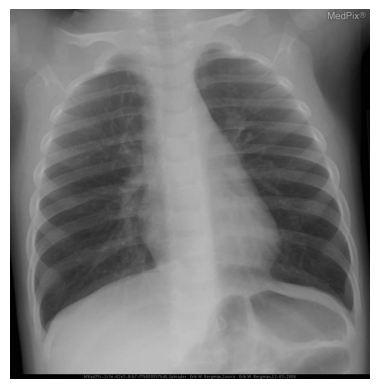

✅ Correct!


In [ ]:
import random
import matplotlib.pyplot as plt

# 1. 确保模型处于评估模式 (Evaluation Mode)
model.eval()

# 2. 从测试集(Test Set)里随机挑一个幸运样本
# 你可以多运行几次这个代码块，抽查不同的病人
sample = test_dataset.data.iloc[random.randint(0, len(test_dataset)-1)]

# 3. 准备数据
image_bytes = sample['image']['bytes']
image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
question = sample['question']
ground_truth = sample['answer']

# 4. 让模型预测 (Inference)
# 这一步不需要 Label，只需要 input_ids 和 pixel_values
inputs = processor(images=image, text=question, return_tensors="pt").to("cuda") # 记得放到 GPU

print("-" * 30)
print(f"❓ Question: {question}")

# 生成答案
# max_new_tokens=10: 医疗答案通常很短 (Yes/No, Left/Right)
generated_ids = model.generate(**inputs, max_new_tokens=10)
predicted_answer = processor.decode(generated_ids[0], skip_special_tokens=True)

print(f"🩺 Ground Truth (医生): {ground_truth}")
print(f"🤖 Model Prediction (AI): {predicted_answer}")
print("-" * 30)

# 5. 展示图片 (直观感受)
plt.imshow(image)
plt.axis('off')
plt.show()

# 简单的判断
if predicted_answer.lower() == ground_truth.lower():
    print("✅ Correct!")
else:
    print("❌ Incorrect (但看看是不是意思相近?)")

In [ ]:
import torch
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# 1. 准备评估函数
def evaluate_model(model, dataset, processor):
    model.eval()
    predictions = []
    ground_truths = []
    question_types = [] # 记录是 Yes/No 还是 其他

    print(f"Starting evaluation on {len(dataset)} test samples...")

    # 使用 tqdm 显示进度条
    for i in tqdm(range(len(dataset))):
        sample = dataset.data.iloc[i]

        # 准备图片
        image_bytes = sample['image']['bytes']
        image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
        question = sample['question']
        ground_truth = sample['answer']

        # 记录问题类型 (简单启发式：如果答案是 yes/no，就归为 Closed)
        if ground_truth.lower() in ['yes', 'no']:
            q_type = 'Closed'
        else:
            q_type = 'Open'

        # 推理
        inputs = processor(images=image, text=question, return_tensors="pt").to(model.device)

        with torch.no_grad():
            # max_new_tokens=10 足够覆盖绝大多数医疗简答
            generated_ids = model.generate(**inputs, max_new_tokens=10)
            pred = processor.decode(generated_ids[0], skip_special_tokens=True)

        predictions.append(pred.lower().strip())
        ground_truths.append(ground_truth.lower().strip())
        question_types.append(q_type)

    return predictions, ground_truths, question_types

# 2. 执行评估 (这可能需要 2-3 分钟)
# 确保模型在 GPU 上
model.to("cuda")
preds, truths, types = evaluate_model(model, test_dataset, processor)

# 3. 整理结果到 DataFrame
results_df = pd.DataFrame({
    'Question Type': types,
    'Ground Truth': truths,
    'Prediction': preds
})

# 4. 计算核心指标 (Metrics)
print("\n" + "="*40)
print("📊 FINAL EVALUATION REPORT")
print("="*40)

# --- A. 总体准确率 (Exact Match Accuracy) ---
total_acc = accuracy_score(truths, preds)
print(f"🏆 Overall Accuracy: {total_acc:.2%}")

# --- B. 分类准确率 (Closed vs Open) ---
# 提取 Closed 问题
closed_mask = results_df['Question Type'] == 'Closed'
closed_acc = accuracy_score(results_df[closed_mask]['Ground Truth'],
                            results_df[closed_mask]['Prediction'])

# 提取 Open 问题
open_mask = results_df['Question Type'] == 'Open'
open_acc = accuracy_score(results_df[open_mask]['Ground Truth'],
                          results_df[open_mask]['Prediction'])

print(f"✅ Closed-ended (Yes/No) Accuracy: {closed_acc:.2%}")
print(f"📝 Open-ended (Descriptive) Accuracy: {open_acc:.2%}")
print("="*40)

# 5. 保存结果到 CSV (为写报告做准备)
save_path = "/content/drive/MyDrive/WOA7015_Project/evaluation_results.csv"
results_df.to_csv(save_path, index=False)
print(f"💾 Detailed results saved to: {save_path}")

# 6. 展示几个错误案例 (Error Analysis 素材)
print("\n🔍 Sample Errors (for Qualitative Analysis):")
errors = results_df[results_df['Ground Truth'] != results_df['Prediction']].head(5)
print(errors)

Starting evaluation on 361 test samples...


100%|██████████| 361/361 [00:47<00:00,  7.63it/s]



📊 FINAL EVALUATION REPORT
🏆 Overall Accuracy: 43.77%
✅ Closed-ended (Yes/No) Accuracy: 69.00%
📝 Open-ended (Descriptive) Accuracy: 12.42%
💾 Detailed results saved to: /content/drive/MyDrive/WOA7015_Project/evaluation_results.csv

🔍 Sample Errors (for Qualitative Analysis):
   Question Type                                       Ground Truth  \
1           Open                                blind loop syndrome   
2           Open  blind-ending loop of bowel arising from the cecum   
6           Open                                            mri-dwi   
8         Closed                                                yes   
11        Closed                                                yes   

               Prediction  
1   right subdural hemato  
2    ring - lesion in the  
6                   brain  
8                      no  
11                     no  


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from collections import Counter
from PIL import Image
import io
from torchvision import transforms, models

# 1. 读取之前保存的数据 (确保数据一致性)
load_path = '/content/drive/MyDrive/WOA7015_Project/data'
train_df = pd.read_pickle(f"{load_path}/train.pkl")
test_df = pd.read_pickle(f"{load_path}/test.pkl")

# 2. 构建答案词表 (Answer Vocabulary) - 这是一个分类任务
# 我们只取出现次数最多的前 1000 个答案，剩下的归为 "unknown"
all_answers = train_df['answer'].tolist()
answer_counts = Counter(all_answers)
sorted_answers = [ans for ans, _ in answer_counts.most_common(1000)]
ans_to_idx = {ans: i for i, ans in enumerate(sorted_answers)}
idx_to_ans = {i: ans for i, ans in enumerate(sorted_answers)}
num_classes = len(ans_to_idx)
print(f"Baseline Answer Vocab Size: {num_classes}")

# 3. 构建问题词表 (Question Vocabulary)
all_questions = " ".join(train_df['question'].tolist()).split()
vocab_counts = Counter(all_questions)
# 简单的词表：出现超过1次的词都算
vocab = ["<pad>", "<unk>"] + [word for word, count in vocab_counts.items() if count > 0]
word_to_idx = {word: i for i, word in enumerate(vocab)}
print(f"Baseline Question Vocab Size: {len(vocab)}")

# 4. 文本处理函数
def encode_text(text, max_len=20):
    tokens = text.lower().split()
    idxs = [word_to_idx.get(t, word_to_idx["<unk>"]) for t in tokens]
    # Padding / Truncating
    if len(idxs) < max_len:
        idxs += [word_to_idx["<pad>"]] * (max_len - len(idxs))
    else:
        idxs = idxs[:max_len]
    return torch.tensor(idxs)

# 5. 图片处理 (标准 ResNet 预处理)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Baseline Answer Vocab Size: 352
Baseline Question Vocab Size: 1255


In [ ]:
class BaselineDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = self.df.iloc[idx]

        # 图片
        img = Image.open(io.BytesIO(item['image']['bytes'])).convert('RGB')
        img = self.transform(img)

        # 问题
        q_tensor = encode_text(item['question'])

        # 答案 (Label)
        ans_label = ans_to_idx.get(item['answer'], -1) # -1 表示不在词表里
        # 如果答案不在前1000个里，我们可以简单的把它设为 0 (或者忽略，这里简单设为0)
        if ans_label == -1: ans_label = 0

        return img, q_tensor, torch.tensor(ans_label)

# 简单的 CNN-LSTM 模型
class CNN_LSTM_VQA(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(CNN_LSTM_VQA, self).__init__()

        # 1. Image Encoder (ResNet18)
        resnet = models.resnet18(pretrained=True)
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-1]) # 去掉最后分类层
        self.img_proj = nn.Linear(512, hidden_size) # 把 ResNet 的 512 维投影到 hidden_size

        # 2. Text Encoder (LSTM)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)

        # 3. Classifier
        self.fc = nn.Linear(hidden_size * 2, num_classes) # 图片特征 + 文本特征

    def forward(self, img, question):
        # Image Branch
        with torch.no_grad(): # 冻结 ResNet 骨干，只训练投影层，加快速度
            img_feat = self.resnet_features(img)
        img_feat = img_feat.view(img_feat.size(0), -1)
        img_feat = self.img_proj(img_feat) # [batch, hidden]

        # Text Branch
        embeds = self.embedding(question)
        _, (h_n, _) = self.lstm(embeds)
        text_feat = h_n[-1] # [batch, hidden]

        # Fusion (Concatenation)
        combined = torch.cat((img_feat, text_feat), dim=1)

        # Classification
        output = self.fc(combined)
        return output

# 实例化
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model = CNN_LSTM_VQA(
    vocab_size=len(vocab),
    embed_size=256,
    hidden_size=512,
    num_classes=num_classes
).to(device)

print("Baseline Model Created: CNN(ResNet18) + LSTM")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 65.9MB/s]


Baseline Model Created: CNN(ResNet18) + LSTM


In [ ]:
train_dataset = BaselineDataset(train_df, transform)
test_dataset = BaselineDataset(test_df, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# Test Loader batch_size=1 用于下面逐个评估
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)

print("Starting Baseline Training...")
for epoch in range(10): # 跑 10 个 epoch
    baseline_model.train()
    total_loss = 0
    for imgs, qs, labels in train_loader:
        imgs, qs, labels = imgs.to(device), qs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = baseline_model(imgs, qs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/10], Loss: {total_loss/len(train_loader):.4f}")

print("Baseline Training Finished.")

Starting Baseline Training...
Epoch [1/10], Loss: 4.2986
Epoch [2/10], Loss: 3.3773
Epoch [3/10], Loss: 2.7797
Epoch [4/10], Loss: 2.3414
Epoch [5/10], Loss: 1.9237
Epoch [6/10], Loss: 1.4961
Epoch [7/10], Loss: 1.3010
Epoch [8/10], Loss: 1.1881
Epoch [9/10], Loss: 1.1749
Epoch [10/10], Loss: 1.1001
Baseline Training Finished.


In [ ]:
baseline_model.eval()
predictions = []
ground_truths = []
question_types = []

print("Evaluating Baseline...")
with torch.no_grad():
    for imgs, qs, labels in test_loader:
        imgs, qs = imgs.to(device), qs.to(device)

        # 获取真实文本答案
        # 注意：DataLoader 会把 labels 变成 Tensor，这里我们需要从 DataFrame 原始数据里拿对应的 Truth
        # 为了方便，这里我们简单还原
        gt_idx = labels.item()
        ground_truth = idx_to_ans.get(gt_idx, "unknown")

        # 预测
        outputs = baseline_model(imgs, qs)
        _, predicted_idx = torch.max(outputs, 1)
        predicted_ans = idx_to_ans.get(predicted_idx.item(), "unknown")

        predictions.append(predicted_ans)
        ground_truths.append(ground_truth)

        # 判断类型 (简单逻辑)
        if ground_truth in ['yes', 'no']:
            question_types.append('Closed')
        else:
            question_types.append('Open')

# 计算 Baseline 的分数
results_df_base = pd.DataFrame({
    'Question Type': question_types,
    'Ground Truth': ground_truths,
    'Prediction': predictions
})

base_acc = accuracy_score(ground_truths, predictions)
print("\n" + "="*40)
print("📉 BASELINE RESULTS (CNN-LSTM)")
print("="*40)
print(f"🏆 Overall Accuracy: {base_acc:.2%}")

closed_mask = results_df_base['Question Type'] == 'Closed'
print(f"✅ Closed Accuracy: {accuracy_score(results_df_base[closed_mask]['Ground Truth'], results_df_base[closed_mask]['Prediction']):.2%}")

open_mask = results_df_base['Question Type'] == 'Open'
print(f"📝 Open Accuracy: {accuracy_score(results_df_base[open_mask]['Ground Truth'], results_df_base[open_mask]['Prediction']):.2%}")

Evaluating Baseline...

📉 BASELINE RESULTS (CNN-LSTM)
🏆 Overall Accuracy: 29.09%
✅ Closed Accuracy: 34.32%
📝 Open Accuracy: 1.72%


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# 重新初始化模型（清除之前的权重，从头开始）
baseline_model = CNN_LSTM_VQA(
    vocab_size=len(vocab),
    embed_size=256,
    hidden_size=512,
    num_classes=num_classes
).to(device)

optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 记录器
history = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [] # 我们用 test_loader 做 validation 来看泛化能力
}

print("Starting Diagnosis Training (15 Epochs)...")

for epoch in range(15): # 多跑几轮看看
    baseline_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # --- 训练循环 ---
    for imgs, qs, labels in train_loader:
        imgs, qs, labels = imgs.to(device), qs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = baseline_model(imgs, qs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 计算训练集准确率
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct_train / total_train

    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)

    # --- 验证循环 (使用测试集) ---
    baseline_model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for imgs, qs, labels in test_loader:
            imgs, qs, labels = imgs.to(device), qs.to(device), labels.to(device)
            outputs = baseline_model(imgs, qs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = 100 * correct_val / total_val
    history['val_acc'].append(val_acc)

    print(f"Epoch [{epoch+1}/15] Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}% | Val Acc: {val_acc:.2f}%")

print("Diagnosis Training Finished.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting Diagnosis Training (15 Epochs)...
Epoch [1/15] Loss: 4.3407 | Train Acc: 25.35% | Val Acc: 28.53%
Epoch [2/15] Loss: 3.3250 | Train Acc: 32.82% | Val Acc: 45.43%
Epoch [3/15] Loss: 2.7872 | Train Acc: 34.08% | Val Acc: 28.81%
Epoch [4/15] Loss: 2.3267 | Train Acc: 36.03% | Val Acc: 45.15%
Epoch [5/15] Loss: 1.7286 | Train Acc: 45.67% | Val Acc: 38.78%
Epoch [6/15] Loss: 1.4410 | Train Acc: 52.03% | Val Acc: 34.63%
Epoch [7/15] Loss: 1.3399 | Train Acc: 51.05% | Val Acc: 33.52%
Epoch [8/15] Loss: 1.2807 | Train Acc: 54.75% | Val Acc: 33.80%
Epoch [9/15] Loss: 1.1959 | Train Acc: 53.63% | Val Acc: 41.00%
Epoch [10/15] Loss: 1.1382 | Train Acc: 55.59% | Val Acc: 31.30%
Epoch [11/15] Loss: 1.1013 | Train Acc: 57.12% | Val Acc: 32.13%
Epoch [12/15] Loss: 1.0840 | Train Acc: 59.43% | Val Acc: 29.64%
Epoch [13/15] Loss: 1.0623 | Train Acc: 56.70% | Val Acc: 34.63%
Epoch [14/15] Loss: 0.9656 | Train Acc: 63.13% | Val Acc: 28.25%
Epoch [15/15] Loss: 0.9146 | Train Acc: 62.71% | Val Acc

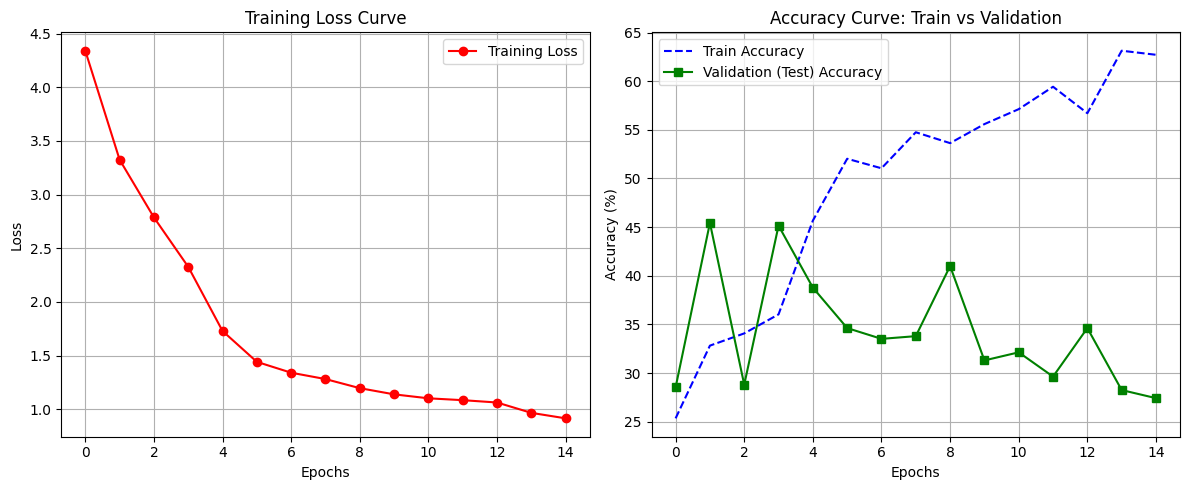

In [ ]:
plt.figure(figsize=(12, 5))

# 图 1: Loss 曲线 (看模型有没有在学习)
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss', color='red', marker='o')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# 图 2: Accuracy 曲线 (看有没有过拟合)
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy', color='blue', linestyle='--')
plt.plot(history['val_acc'], label='Validation (Test) Accuracy', color='green', marker='s')
plt.title('Accuracy Curve: Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Index for 'yes': 1, Index for 'no': 0


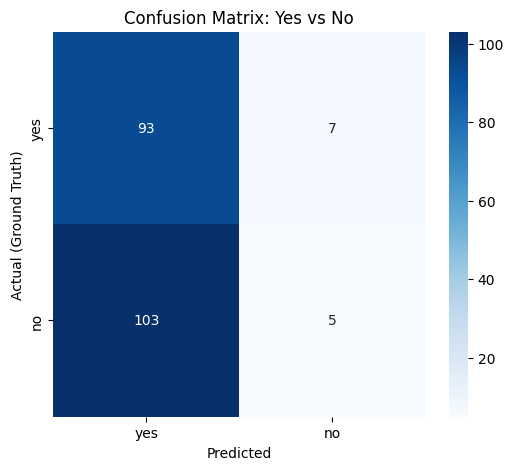

              precision    recall  f1-score   support

         yes       0.47      0.92      0.63       101
          no       0.42      0.02      0.05       202

   micro avg       0.47      0.32      0.38       303
   macro avg       0.45      0.47      0.34       303
weighted avg       0.44      0.32      0.24       303



In [ ]:
# 专门分析 Yes/No (Closed) 问题
baseline_model.eval()
y_true = []
y_pred = []

# 获取 Yes 和 No 在词表里的 ID
yes_idx = ans_to_idx.get('yes')
no_idx = ans_to_idx.get('no')

print(f"Index for 'yes': {yes_idx}, Index for 'no': {no_idx}")

with torch.no_grad():
    for imgs, qs, labels in test_loader:
        imgs, qs = imgs.to(device), qs.to(device)
        labels = labels.to(device)

        # 只关心真实答案是 yes 或 no 的样本
        if labels.item() in [yes_idx, no_idx]:
            outputs = baseline_model(imgs, qs)
            _, predicted = torch.max(outputs, 1)

            y_true.append(labels.item())
            y_pred.append(predicted.item())

# 转换回文本方便看
y_true_text = [idx_to_ans[i] for i in y_true]
y_pred_text = [idx_to_ans.get(i, "other") for i in y_pred]

# 画混淆矩阵
cm = confusion_matrix(y_true_text, y_pred_text, labels=["yes", "no"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["yes", "no"], yticklabels=["yes", "no"])
plt.xlabel('Predicted')
plt.ylabel('Actual (Ground Truth)')
plt.title('Confusion Matrix: Yes vs No')
plt.show()

# 打印详细分类报告
from sklearn.metrics import classification_report
print(classification_report(y_true_text, y_pred_text, labels=["yes", "no"]))

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn

# 重新初始化模型
baseline_model = CNN_LSTM_VQA(
    vocab_size=len(vocab),
    embed_size=256,
    hidden_size=512,
    num_classes=num_classes
).to(device)

optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 记录器 (新增了 val_loss)
history = {
    'train_loss': [],
    'val_loss': [],  # <--- 新增
    'train_acc': [],
    'val_acc': []
}

print("Starting Baseline Training with Val Loss Tracking...")

for epoch in range(15):
    # --- 训练阶段 ---
    baseline_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for imgs, qs, labels in train_loader:
        imgs, qs, labels = imgs.to(device), qs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = baseline_model(imgs, qs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct_train / total_train

    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)

    # --- 验证阶段 (修正版：计算 Loss) ---
    baseline_model.eval()
    val_running_loss = 0.0 # <--- 新增
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for imgs, qs, labels in test_loader:
            imgs, qs, labels = imgs.to(device), qs.to(device), labels.to(device)

            outputs = baseline_model(imgs, qs)

            # --- 新增：计算验证集 Loss ---
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            # --------------------------

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(test_loader) # <--- 计算平均 Val Loss
    val_acc = 100 * correct_val / total_val

    history['val_loss'].append(val_loss) # <--- 记录
    history['val_acc'].append(val_acc)

    print(f"Epoch [{epoch+1}/15] Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

print("✅ Training Finished.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting Baseline Training with Val Loss Tracking...
Epoch [1/15] Train Loss: 4.2375 | Val Loss: 2.1922 | Val Acc: 46.26%
Epoch [2/15] Train Loss: 3.2870 | Val Loss: 2.5880 | Val Acc: 27.98%
Epoch [3/15] Train Loss: 2.7478 | Val Loss: 2.4949 | Val Acc: 40.17%
Epoch [4/15] Train Loss: 2.1376 | Val Loss: 2.6358 | Val Acc: 32.41%
Epoch [5/15] Train Loss: 1.7296 | Val Loss: 2.4351 | Val Acc: 40.44%
Epoch [6/15] Train Loss: 1.5693 | Val Loss: 2.6078 | Val Acc: 37.95%
Epoch [7/15] Train Loss: 1.4530 | Val Loss: 2.5281 | Val Acc: 32.41%
Epoch [8/15] Train Loss: 1.2997 | Val Loss: 2.7294 | Val Acc: 39.89%
Epoch [9/15] Train Loss: 1.2080 | Val Loss: 2.9625 | Val Acc: 39.06%
Epoch [10/15] Train Loss: 1.1669 | Val Loss: 2.9198 | Val Acc: 41.27%
Epoch [11/15] Train Loss: 1.3265 | Val Loss: 3.0714 | Val Acc: 34.90%
Epoch [12/15] Train Loss: 1.0803 | Val Loss: 3.1468 | Val Acc: 34.63%
Epoch [13/15] Train Loss: 1.0756 | Val Loss: 3.1371 | Val Acc: 35.73%
Epoch [14/15] Train Loss: 1.0127 | Val Loss: 3

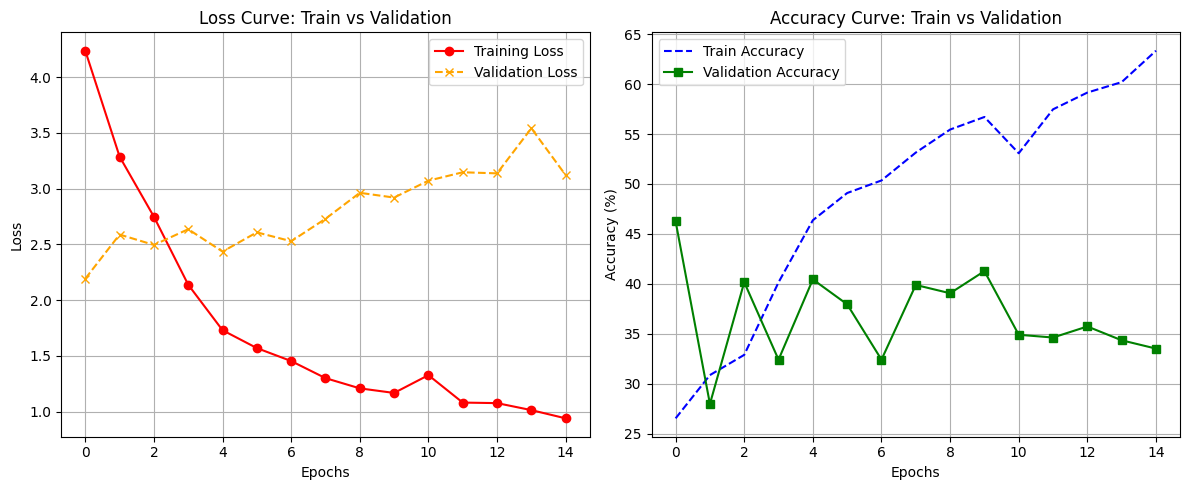

In [ ]:
plt.figure(figsize=(12, 5))

# 图 1: Loss 对比 (核心证据)
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss', color='red', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', color='orange', marker='x', linestyle='--') # 新增
plt.title('Loss Curve: Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# 图 2: Accuracy 对比
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy', color='blue', linestyle='--')
plt.plot(history['val_acc'], label='Validation Accuracy', color='green', marker='s')
plt.title('Accuracy Curve: Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import torch
import io
from PIL import Image
from torch.utils.data import Dataset
from transformers import (
    BlipProcessor,
    BlipForQuestionAnswering,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

# ==========================================
# 1. 准备数据 (加载 & 定义 Dataset 类)
# ==========================================
print("Step 1: Reloading Data and Processor...")

# 加载处理器
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

# 读取之前保存的数据
load_path = '/content/drive/MyDrive/WOA7015_Project/data'
try:
    train_df = pd.read_pickle(f"{load_path}/train.pkl")
    test_df = pd.read_pickle(f"{load_path}/test.pkl")
    print(f"Loaded {len(train_df)} training samples")
except FileNotFoundError:
    print("Error: Data files not found. Please check your Drive path.")
    raise

# --- 重新定义 Dataset 类 (确保它是最新的) ---
class MedicalVQADataset(Dataset):
    def __init__(self, dataframe, processor):
        self.data = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]

        # 1. 处理图片
        image_data = item['image']
        if isinstance(image_data, dict) and 'bytes' in image_data:
            image = Image.open(io.BytesIO(image_data['bytes'])).convert('RGB')
        else:
            image = image_data

        # 2. 处理文本
        question = item['question']
        answer = item['answer']

        # 3. 编码 (Encoding)
        encoding = self.processor(
            images=image,
            text=question,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # 4. 处理答案 Label
        labels = self.processor.tokenizer.encode(
            answer,
            max_length=8,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # 5. 格式化返回 (关键：必须返回标准字典)
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding['labels'] = labels.squeeze()

        return encoding

# 实例化 Dataset
print("Step 2: Instantiating Datasets...")
train_dataset = MedicalVQADataset(train_df, processor)
test_dataset = MedicalVQADataset(test_df, processor)

# 自检：确保数据格式是字典
print(f"Format Check (Should be dict): {type(train_dataset[0])}")

# ==========================================
# 2. 配置模型与训练 (优化版)
# ==========================================
print("Step 3: Loading Model and Configuring Trainer...")

model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# 自定义 Trainer (修复 Transformers 库兼容性问题)
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        if "num_items_in_batch" in inputs:
            del inputs["num_items_in_batch"]
        return super().compute_loss(model, inputs, return_outputs)

# 训练参数 (15 Epochs + Early Stopping)
training_args = TrainingArguments(
    output_dir="./results_blip_optimized",
    num_train_epochs=15,              # 最多跑 15 轮
    per_device_train_batch_size=2,    # 显存优化
    gradient_accumulation_steps=8,    # 梯度累积
    learning_rate=5e-5,
    logging_steps=20,

    # 评估与早停配置
    eval_strategy="steps",
    eval_steps=100,                   # 每 100 步评估一次
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,      # 训练结束自动回滚到最好的模型
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    remove_unused_columns=False,
    push_to_hub=False,
    fp16=True,
    dataloader_num_workers=0,
    report_to="none"                  # 屏蔽 WandB
)

# 初始化 Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] # 连续 3 次没变好就停
)

# ==========================================
# 3. 开始训练
# ==========================================
print("Starting Optimized Training...")
trainer.train()

# 保存最佳模型
save_path = "./final_blip_optimized"
model.save_pretrained(save_path)
processor.save_pretrained(save_path)
print(f"Optimized Training Finished! Best model saved to {save_path}")

Step 1: Reloading Data and Processor...
Loaded 1432 training samples
Step 2: Instantiating Datasets...
Format Check (Should be dict): <class 'dict'>
Step 3: Loading Model and Configuring Trainer...
Starting Optimized Training...


Step,Training Loss,Validation Loss
100,22.068700,2.221889
200,4.435300,1.258463
300,3.141400,1.232742
400,1.948600,1.241992
500,1.444900,1.310063
600,1.252900,1.295476


There were missing keys in the checkpoint model loaded: ['text_decoder.cls.predictions.decoder.weight', 'text_decoder.cls.predictions.decoder.bias'].


Optimized Training Finished! Best model saved to ./final_blip_optimized


In [ ]:
import pandas as pd
import torch
import io
import os
from PIL import Image
from torch.utils.data import Dataset
from google.colab import drive
from transformers import (
    BlipProcessor,
    BlipForQuestionAnswering,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

# ==========================================
# 0. 挂载云盘 (防灾难第一步)
# ==========================================
drive.mount('/content/drive')
# 定义云盘上的项目主目录
project_path = '/content/drive/MyDrive/WOA7015_Project'
data_path = f"{project_path}/data"
# 关键：这次模型直接存云盘！
model_save_path = f"{project_path}/final_blip_optimized"

print(f"📂 Data will be loaded from: {data_path}")
print(f"💾 Model will be saved to: {model_save_path}")

# ==========================================
# 1. 快速加载数据
# ==========================================
print("🔄 Reloading Data...")
try:
    train_df = pd.read_pickle(f"{data_path}/train.pkl")
    test_df = pd.read_pickle(f"{data_path}/test.pkl")
    print(f"✅ Loaded {len(train_df)} training samples")
except FileNotFoundError:
    print("❌ Error: Data files not found in Drive. Did you skip the ETL step?")
    raise

# 加载处理器
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

# 重新定义 Dataset 类
class MedicalVQADataset(Dataset):
    def __init__(self, dataframe, processor):
        self.data = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        image_data = item['image']
        if isinstance(image_data, dict) and 'bytes' in image_data:
            image = Image.open(io.BytesIO(image_data['bytes'])).convert('RGB')
        else:
            image = image_data

        encoding = self.processor(
            images=image,
            text=item['question'],
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        labels = self.processor.tokenizer.encode(
            item['answer'],
            max_length=8,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding['labels'] = labels.squeeze()
        return encoding

train_dataset = MedicalVQADataset(train_df, processor)
test_dataset = MedicalVQADataset(test_df, processor)

# ==========================================
# 2. 重新开始训练 (直接存云盘版)
# ==========================================
print("🔄 Configuring Trainer...")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        if "num_items_in_batch" in inputs:
            del inputs["num_items_in_batch"]
        return super().compute_loss(model, inputs, return_outputs)

training_args = TrainingArguments(
    output_dir=f"{project_path}/checkpoints", # 检查点也存云盘
    num_train_epochs=15,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=5e-5,
    logging_steps=20,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    remove_unused_columns=False,
    push_to_hub=False,
    fp16=True,
    dataloader_num_workers=0,
    report_to="none"
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("🚀 Restarting Training (Saving directly to Google Drive)...")
trainer.train()

# ==========================================
# 3. 保存与验证
# ==========================================
print(f"💾 Saving final model to {model_save_path}...")
model.save_pretrained(model_save_path)
processor.save_pretrained(model_save_path)
print("✅ Disaster averted! Model is safely in Google Drive.")

Mounted at /content/drive
📂 Data will be loaded from: /content/drive/MyDrive/WOA7015_Project/data
💾 Model will be saved to: /content/drive/MyDrive/WOA7015_Project/final_blip_optimized
🔄 Reloading Data...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ Loaded 1432 training samples


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

🔄 Configuring Trainer...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

🚀 Restarting Training (Saving directly to Google Drive)...


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss,Validation Loss
100,22.068700,2.221889
200,4.435300,1.258463
300,3.141400,1.232742
400,1.948600,1.241992
500,1.444900,1.310063
600,1.252900,1.295476


There were missing keys in the checkpoint model loaded: ['text_decoder.cls.predictions.decoder.weight', 'text_decoder.cls.predictions.decoder.bias'].


💾 Saving final model to /content/drive/MyDrive/WOA7015_Project/final_blip_optimized...
✅ Disaster averted! Model is safely in Google Drive.


📊 Extracting training logs...


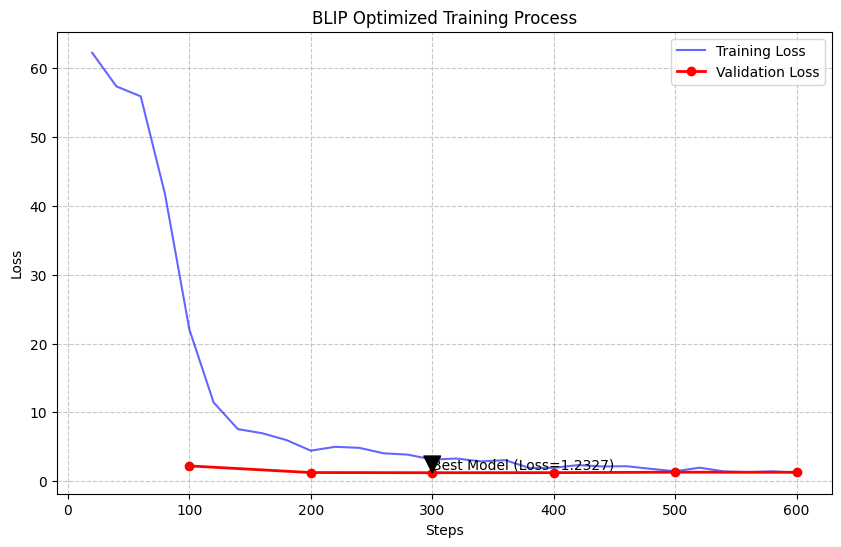

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. 检查 Trainer 是否存在
if 'trainer' in locals() and trainer.state.log_history:
    print("📊 Extracting training logs...")
    log_history = trainer.state.log_history

    # 提取数据
    train_steps = []
    train_loss = []
    eval_steps = []
    eval_loss = []

    for entry in log_history:
        if 'loss' in entry:
            train_steps.append(entry['step'])
            train_loss.append(entry['loss'])
        if 'eval_loss' in entry:
            eval_steps.append(entry['step'])
            eval_loss.append(entry['eval_loss'])

    # 2. 开始画图
    plt.figure(figsize=(10, 6))

    # 绘制训练曲线
    plt.plot(train_steps, train_loss, label='Training Loss', color='blue', alpha=0.6)

    # 绘制验证曲线 (如果有的话)
    if eval_loss:
        plt.plot(eval_steps, eval_loss, label='Validation Loss', color='red', marker='o', linewidth=2)

    plt.title('BLIP Optimized Training Process')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # 标记最佳点 (早停点通常在验证Loss最低处)
    if eval_loss:
        min_loss = min(eval_loss)
        min_idx = eval_loss.index(min_loss)
        best_step = eval_steps[min_idx]
        plt.annotate(f'Best Model (Loss={min_loss:.4f})',
                     xy=(best_step, min_loss),
                     xytext=(best_step, min_loss + 0.5),
                     arrowprops=dict(facecolor='black', shrink=0.05))

    plt.show()
else:
    print("⚠️ Trainer logs not found. Did you restart the runtime? Skipping visualization.")

🔄 Loading model from Google Drive: /content/drive/MyDrive/WOA7015_Project/final_blip_optimized...
✅ Model loaded successfully!
🚀 Starting evaluation with Beam Search (num_beams=3)...


100%|██████████| 361/361 [00:45<00:00,  7.85it/s]



📊 FINAL BLIP RESULTS
🏆 Overall Accuracy: 37.12%
✅ Closed Accuracy: 60.50%
📝 Open Accuracy:   8.07%

🔍 Generating Confusion Matrix...


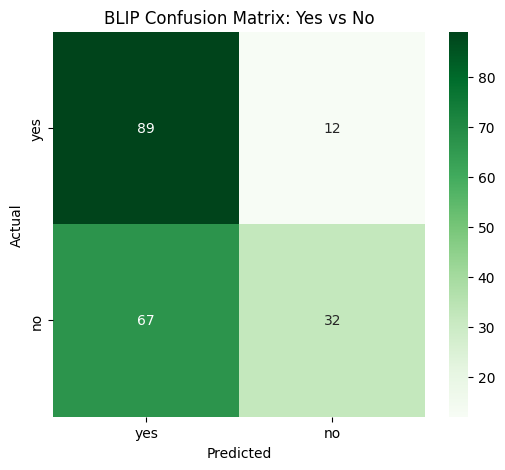

💾 Results saved to /content/drive/MyDrive/WOA7015_Project/final_evaluation_results.csv


In [ ]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import os
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BlipForQuestionAnswering, BlipProcessor
from torch.utils.data import Dataset
from google.colab import drive

# ==========================================
# 0. 准备路径 & 挂载
# ==========================================
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

project_path = '/content/drive/MyDrive/WOA7015_Project'
model_path = f"{project_path}/final_blip_optimized"
data_path = f"{project_path}/data"

# ==========================================
# 1. 智能加载模型
# ==========================================
print(f"🔄 Loading model from Google Drive: {model_path}...")
try:
    model = BlipForQuestionAnswering.from_pretrained(model_path)
    processor = BlipProcessor.from_pretrained(model_path)
    model.to("cuda")
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

# ==========================================
# 2. 智能准备测试数据
# ==========================================
# 如果内存里没有 test_dataset，我们需要重新定义类并加载
if 'test_dataset' not in locals():
    print("⚠️ test_dataset not found in memory. Reloading from disk...")

    # 重新定义 Dataset 类 (防止丢失)
    class MedicalVQADataset(Dataset):
        def __init__(self, dataframe, processor):
            self.data = dataframe
            self.processor = processor
        def __len__(self):
            return len(self.data)
        def __getitem__(self, idx):
            item = self.data.iloc[idx]
            image_data = item['image']
            if isinstance(image_data, dict) and 'bytes' in image_data:
                image = Image.open(io.BytesIO(image_data['bytes'])).convert('RGB')
            else:
                image = image_data
            return image, item['question'], item['answer'] # 简化版返回，方便 Eval 使用

    test_df = pd.read_pickle(f"{data_path}/test.pkl")
    test_dataset = MedicalVQADataset(test_df, processor)
    print(f"✅ Re-loaded {len(test_dataset)} test samples.")

# ==========================================
# 3. 执行评估循环
# ==========================================
def evaluate_model(model, dataset, processor):
    model.eval()
    predictions = []
    ground_truths = []
    question_types = []

    print(f"🚀 Starting evaluation with Beam Search (num_beams=3)...")

    for i in tqdm(range(len(dataset))):
        # ... (数据读取部分保持不变) ...
        sample = dataset.data.iloc[i]
        image_data = sample['image']
        if isinstance(image_data, dict) and 'bytes' in image_data:
            image = Image.open(io.BytesIO(image_data['bytes'])).convert('RGB')
        else:
            image = image_data

        question = sample['question']
        ground_truth = sample['answer']

        if ground_truth.lower() in ['yes', 'no']:
            q_type = 'Closed'
        else:
            q_type = 'Open'

        inputs = processor(images=image, text=question, return_tensors="pt").to(model.device)

        with torch.no_grad():
            # --- 修改在这里 ---
            generated_ids = model.generate(
                **inputs,
                max_new_tokens=10,
                num_beams=3,        # 开启 Beam Search
                early_stopping=True # 配合 Beam Search 使用
            )
            # ----------------

            pred = processor.decode(generated_ids[0], skip_special_tokens=True)

        predictions.append(pred.lower().strip())
        ground_truths.append(ground_truth.lower().strip())
        question_types.append(q_type)

    return predictions, ground_truths, question_types

# 运行评估
preds, truths, types = evaluate_model(model, test_dataset, processor)

# ==========================================
# 4. 展示结果 & 混淆矩阵
# ==========================================
results_df = pd.DataFrame({'Type': types, 'GT': truths, 'Pred': preds})

print("\n" + "="*40)
print("📊 FINAL BLIP RESULTS")
print("="*40)

# A. 准确率
total_acc = accuracy_score(truths, preds)
print(f"🏆 Overall Accuracy: {total_acc:.2%}")

closed_mask = results_df['Type'] == 'Closed'
open_mask = results_df['Type'] == 'Open'
print(f"✅ Closed Accuracy: {accuracy_score(results_df[closed_mask]['GT'], results_df[closed_mask]['Pred']):.2%}")
print(f"📝 Open Accuracy:   {accuracy_score(results_df[open_mask]['GT'], results_df[open_mask]['Pred']):.2%}")

# B. 混淆矩阵 (Yes/No)
print("\n🔍 Generating Confusion Matrix...")
yes_no_df = results_df[results_df['GT'].isin(['yes', 'no'])]
y_true = yes_no_df['GT']
# 清洗预测值：只要不是 yes/no 都归为 'other'
y_pred = yes_no_df['Pred'].apply(lambda x: x if x in ['yes', 'no'] else 'other')

cm = confusion_matrix(y_true, y_pred, labels=["yes", "no"])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=["yes", "no"], yticklabels=["yes", "no"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('BLIP Confusion Matrix: Yes vs No')
plt.show()

# 保存结果
save_path = f"{project_path}/final_evaluation_results.csv"
results_df.to_csv(save_path, index=False)
print(f"💾 Results saved to {save_path}")

In [ ]:
import pandas as pd
import torch
import io
import os
from PIL import Image
from torch.utils.data import Dataset
from google.colab import drive
from transformers import (
    BlipProcessor,
    BlipForQuestionAnswering,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

# ==========================================
# 0. 准备工作
# ==========================================
# 挂载云盘
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

project_path = '/content/drive/MyDrive/WOA7015_Project'
data_path = f"{project_path}/data"
# 我们换个名字保存，方便和上一次的做对比
model_save_path = f"{project_path}/final_blip_retrained_p5"

print(f"📂 Reading data from: {data_path}")
print(f"💾 Model will be saved to: {model_save_path}")

# ==========================================
# 1. 加载数据
# ==========================================
print("🔄 Reloading Data...")
try:
    train_df = pd.read_pickle(f"{data_path}/train.pkl")
    test_df = pd.read_pickle(f"{data_path}/test.pkl")
    print(f"✅ Loaded {len(train_df)} training samples")
except FileNotFoundError:
    print("❌ Error: Data files not found. Please check path.")
    raise

# 加载处理器
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

# 定义 Dataset
class MedicalVQADataset(Dataset):
    def __init__(self, dataframe, processor):
        self.data = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        image_data = item['image']
        if isinstance(image_data, dict) and 'bytes' in image_data:
            image = Image.open(io.BytesIO(image_data['bytes'])).convert('RGB')
        else:
            image = image_data

        encoding = self.processor(
            images=image,
            text=item['question'],
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        labels = self.processor.tokenizer.encode(
            item['answer'],
            max_length=8,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding['labels'] = labels.squeeze()
        return encoding

train_dataset = MedicalVQADataset(train_df, processor)
test_dataset = MedicalVQADataset(test_df, processor)

# ==========================================
# 2. 配置训练 (Strategy V2)
# ==========================================
print("🔄 Configuring Trainer (Strategy V2)...")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        if "num_items_in_batch" in inputs:
            del inputs["num_items_in_batch"]
        return super().compute_loss(model, inputs, return_outputs)

training_args = TrainingArguments(
    output_dir=f"{project_path}/checkpoints_v2",

    # --- 核心调整 ---
    num_train_epochs=20,              # 拉长上限，给 Patience=5 留出空间
    learning_rate=5e-5,               # 保持不变

    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,

    logging_steps=50,                 # 【改动】加密日志，画图更细腻

    eval_strategy="steps",
    eval_steps=50,                    # 【改动】每 50 步就评估一次，捕捉更细微的变化
    save_strategy="steps",
    save_steps=50,                    # 必须和 eval 保持一致

    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    # ----------------

    remove_unused_columns=False,
    push_to_hub=False,
    fp16=True,
    dataloader_num_workers=0,
    report_to="none"
)

# 初始化 Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    # 【改动】Patience 加到 5
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

# ==========================================
# 3. 开始训练
# ==========================================
print("🚀 Starting Retraining (Max 20 Epochs, Patience=5, Log=50)...")
trainer.train()

# 保存
print(f"💾 Saving V2 model to {model_save_path}...")
model.save_pretrained(model_save_path)
processor.save_pretrained(model_save_path)
print("✅ Retraining Finished! Ready for comparison.")

📂 Reading data from: /content/drive/MyDrive/WOA7015_Project/data
💾 Model will be saved to: /content/drive/MyDrive/WOA7015_Project/final_blip_retrained_p5
🔄 Reloading Data...
✅ Loaded 1432 training samples
🔄 Configuring Trainer (Strategy V2)...
🚀 Starting Retraining (Max 20 Epochs, Patience=5, Log=50)...


Step,Training Loss,Validation Loss
50,59.040600,7.144700
100,34.189200,2.049964
150,8.686100,1.247474
200,5.532900,1.275059
250,4.835500,1.215502
300,3.619600,1.228347
350,3.096400,1.251423
400,2.279900,1.248585
450,2.377700,1.256689
500,1.784600,1.283854


There were missing keys in the checkpoint model loaded: ['text_decoder.cls.predictions.decoder.weight', 'text_decoder.cls.predictions.decoder.bias'].


💾 Saving V2 model to /content/drive/MyDrive/WOA7015_Project/final_blip_retrained_p5...
✅ Retraining Finished! Ready for comparison.


🔍 Searching for training logs in: /content/drive/MyDrive/WOA7015_Project/checkpoints_v2...
✅ Found log file: /content/drive/MyDrive/WOA7015_Project/checkpoints_v2/checkpoint-500/trainer_state.json


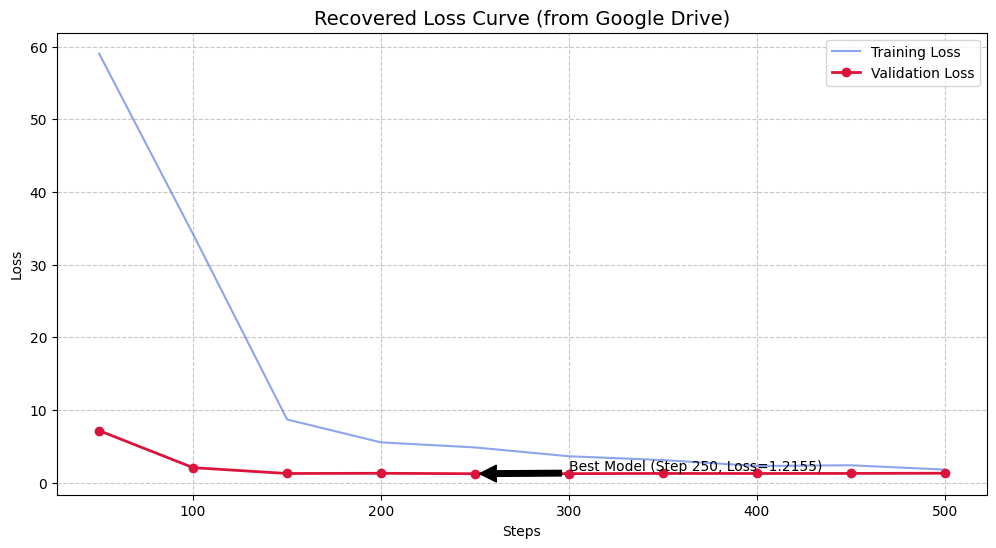

In [ ]:
import json
import os
import matplotlib.pyplot as plt
import glob

# 1. 定义你的 checkpoint 路径 (根据你之前的设置)
project_path = '/content/drive/MyDrive/WOA7015_Project'
checkpoint_dir = f"{project_path}/checkpoints_v2"

print(f"🔍 Searching for training logs in: {checkpoint_dir}...")

# 2. 找到最新的 checkpoint 文件夹
# checkpoint 文件夹通常命名为 checkpoint-50, checkpoint-100 等
checkpoints = glob.glob(f"{checkpoint_dir}/checkpoint-*")

if not checkpoints:
    print("❌ No checkpoints found. Did the training run long enough to save step 50?")
else:
    # 按时间排序，找最新的一个
    latest_checkpoint = max(checkpoints, key=os.path.getctime)
    log_file = os.path.join(latest_checkpoint, "trainer_state.json")

    print(f"✅ Found log file: {log_file}")

    # 3. 读取并解析 JSON 日志
    if os.path.exists(log_file):
        with open(log_file, 'r') as f:
            data = json.load(f)

        log_history = data['log_history']

        train_steps = []
        train_loss = []
        eval_steps = []
        eval_loss = []

        for entry in log_history:
            if 'loss' in entry:
                train_steps.append(entry['step'])
                train_loss.append(entry['loss'])
            if 'eval_loss' in entry:
                eval_steps.append(entry['step'])
                eval_loss.append(entry['eval_loss'])

        # 4. 绘图
        plt.figure(figsize=(12, 6))
        plt.plot(train_steps, train_loss, label='Training Loss', color='royalblue', alpha=0.6)

        if eval_loss:
            plt.plot(eval_steps, eval_loss, label='Validation Loss', color='crimson', marker='o', linewidth=2)

            # 标记最低点
            min_loss = min(eval_loss)
            min_idx = eval_loss.index(min_loss)
            best_step = eval_steps[min_idx]
            plt.annotate(f'Best Model (Step {best_step}, Loss={min_loss:.4f})',
                         xy=(best_step, min_loss),
                         xytext=(best_step + 50, min_loss + 0.5),
                         arrowprops=dict(facecolor='black', shrink=0.05))

        plt.title('Recovered Loss Curve (from Google Drive)', fontsize=14)
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    else:
        print("❌ trainer_state.json not found in the checkpoint folder.")

🔄 Loading model on CPU (This might be slower)...
✅ Model loaded on CPU successfully!
🔄 Reloading Test Dataset...
🚀 Starting evaluation on CPU (361 samples)...
☕ Go grab a coffee, this will take about 5-10 minutes.


100%|██████████| 361/361 [21:36<00:00,  3.59s/it]



📊 FINAL REPORT (CPU Mode)
🏆 Overall Accuracy: 36.29%
✅ Closed Accuracy: 58.00%
📝 Open Accuracy:   9.32%

🔍 Generating Confusion Matrix...


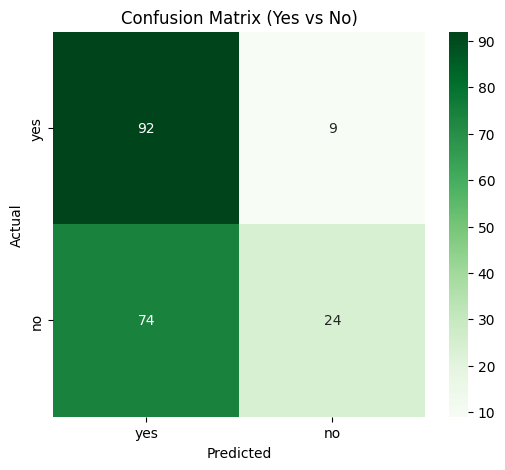

💾 Results saved to /content/drive/MyDrive/WOA7015_Project/final_evaluation_cpu.csv


In [ ]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import os
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BlipForQuestionAnswering, BlipProcessor
from torch.utils.data import Dataset
from google.colab import drive

# 1. 路径配置
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

project_path = '/content/drive/MyDrive/WOA7015_Project'
model_path = f"{project_path}/final_blip_retrained_p5"
data_path = f"{project_path}/data"

# ==========================================
# 2. CPU 模式加载模型 (关键修改)
# ==========================================
print(f"🔄 Loading model on CPU (This might be slower)...")
try:
    # 显式指定 map_location='cpu'
    model = BlipForQuestionAnswering.from_pretrained(model_path).to("cpu")
    processor = BlipProcessor.from_pretrained(model_path)
    print("✅ Model loaded on CPU successfully!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

# ==========================================
# 3. 准备数据
# ==========================================
print("🔄 Reloading Test Dataset...")
class MedicalVQADataset(Dataset):
    def __init__(self, dataframe, processor):
        self.data = dataframe
        self.processor = processor
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        return item

test_df = pd.read_pickle(f"{data_path}/test.pkl")
test_dataset = MedicalVQADataset(test_df, processor)

# ==========================================
# 4. CPU 评估函数
# ==========================================
def evaluate_model_cpu(model, dataset, processor):
    model.eval()
    predictions = []
    ground_truths = []
    question_types = []

    print(f"🚀 Starting evaluation on CPU ({len(dataset)} samples)...")
    print("☕ Go grab a coffee, this will take about 5-10 minutes.")

    for i in tqdm(range(len(dataset))):
        # 获取数据
        try:
            item = dataset.data.iloc[i]
        except:
            item = dataset[i]

        image_data = item['image']
        if isinstance(image_data, dict) and 'bytes' in image_data:
            image = Image.open(io.BytesIO(image_data['bytes'])).convert('RGB')
        else:
            image = image_data

        question = item['question']
        ground_truth = item['answer']

        if ground_truth.lower() in ['yes', 'no']:
            q_type = 'Closed'
        else:
            q_type = 'Open'

        # --- 关键修改：不使用 .to("cuda") ---
        inputs = processor(images=image, text=question, return_tensors="pt")
        # 确保 inputs 也在 cpu 上 (默认就是，但为了保险)
        inputs = {k: v.to("cpu") for k, v in inputs.items()}

        with torch.no_grad():
            # 使用 Beam Search = 3
            generated_ids = model.generate(**inputs, max_new_tokens=10, num_beams=3)
            pred = processor.decode(generated_ids[0], skip_special_tokens=True)

        predictions.append(pred.lower().strip())
        ground_truths.append(ground_truth.lower().strip())
        question_types.append(q_type)

    return predictions, ground_truths, question_types

# 执行评估
preds, truths, types = evaluate_model_cpu(model, test_dataset, processor)

# ==========================================
# 5. 展示结果
# ==========================================
results_df = pd.DataFrame({'Type': types, 'GT': truths, 'Pred': preds})

print("\n" + "="*40)
print("📊 FINAL REPORT (CPU Mode)")
print("="*40)

total_acc = accuracy_score(truths, preds)
print(f"🏆 Overall Accuracy: {total_acc:.2%}")

closed_mask = results_df['Type'] == 'Closed'
open_mask = results_df['Type'] == 'Open'

print(f"✅ Closed Accuracy: {accuracy_score(results_df[closed_mask]['GT'], results_df[closed_mask]['Pred']):.2%}")
print(f"📝 Open Accuracy:   {accuracy_score(results_df[open_mask]['GT'], results_df[open_mask]['Pred']):.2%}")

# 绘制混淆矩阵
print("\n🔍 Generating Confusion Matrix...")
yes_no_df = results_df[results_df['GT'].isin(['yes', 'no'])]
y_true = yes_no_df['GT']
y_pred = yes_no_df['Pred'].apply(lambda x: x if x in ['yes', 'no'] else 'other')

cm = confusion_matrix(y_true, y_pred, labels=["yes", "no"])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=["yes", "no"], yticklabels=["yes", "no"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Yes vs No)')
plt.show()

# 保存结果
save_path = f"{project_path}/final_evaluation_cpu.csv"
results_df.to_csv(save_path, index=False)
print(f"💾 Results saved to {save_path}")

Mounted at /content/drive
🔄 Loading model from: /content/drive/MyDrive/WOA7015_Project/final_blip_retrained_p5 (CPU Mode)...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ Model loaded successfully!
🔄 Loading Test Data...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


✅ Loaded 361 test samples.

==================== FIGURE 5: SUCCESS CASE ====================
🔎 Searching for a representative success case...


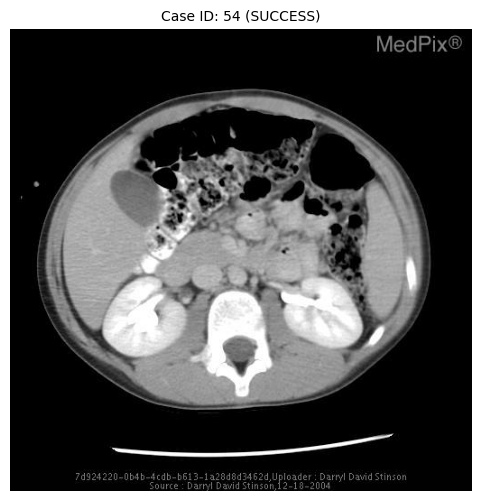

----------------------------------------
❓ Question: how many kidneys are visualizable in this image?
🩺 Ground Truth: 2
🤖 BLIP Prediction: 2
----------------------------------------

==================== FIGURE 6: FAILURE CASE ====================
🔎 Searching for a representative failure case...


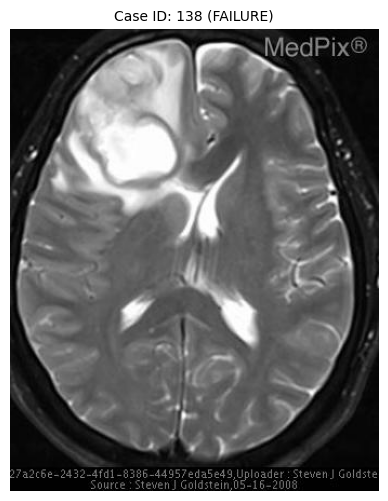

----------------------------------------
❓ Question: is this a viral or parasitic process?
🩺 Ground Truth: parasitic
🤖 BLIP Prediction: multiple scler
----------------------------------------


In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import io
import os
import random
from PIL import Image
from transformers import BlipForQuestionAnswering, BlipProcessor
from google.colab import drive

# ============================
# 1. 准备环境 & 加载模型
# ============================
# 挂载云盘
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

project_path = '/content/drive/MyDrive/WOA7015_Project'
data_path = f"{project_path}/data"
# 指向你最新的最佳模型 (Patience=5 的那个)
model_path = f"{project_path}/final_blip_retrained_p5"

print(f"🔄 Loading model from: {model_path} (CPU Mode)...")
try:
    # 强制使用 CPU 加载，避免显存报错
    model = BlipForQuestionAnswering.from_pretrained(model_path).to("cpu")
    processor = BlipProcessor.from_pretrained(model_path)
    model.eval()
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    # 如果找不到 p5，尝试找 p3 或者原始的
    fallback_path = f"{project_path}/final_blip_optimized"
    print(f"⚠️ Trying fallback path: {fallback_path}")
    model = BlipForQuestionAnswering.from_pretrained(fallback_path).to("cpu")
    processor = BlipProcessor.from_pretrained(fallback_path)
    model.eval()

# 加载测试数据
print("🔄 Loading Test Data...")
test_df = pd.read_pickle(f"{data_path}/test.pkl")
print(f"✅ Loaded {len(test_df)} test samples.")

# ============================
# 2. 定义“淘金”函数
# ============================
def find_case(target_type="success"):
    """
    target_type: "success" (找预测对的) 或 "failure" (找预测错的)
    """
    print(f"🔎 Searching for a representative {target_type} case...")

    # 随机打乱数据，这样每次运行都能看到不同的图
    shuffled_indices = list(range(len(test_df)))
    random.shuffle(shuffled_indices)

    for i in shuffled_indices:
        item = test_df.iloc[i]

        # 处理图片
        image_data = item['image']
        if isinstance(image_data, dict) and 'bytes' in image_data:
            image = Image.open(io.BytesIO(image_data['bytes'])).convert('RGB')
        else:
            image = image_data

        question = item['question']
        ground_truth = item['answer']

        # 推理 (Inference)
        inputs = processor(images=image, text=question, return_tensors="pt")
        with torch.no_grad():
            # 使用 Beam Search 生成更稳健的答案
            generated_ids = model.generate(**inputs, max_new_tokens=20, num_beams=3)
            prediction = processor.decode(generated_ids[0], skip_special_tokens=True)

        prediction = prediction.lower().strip()
        ground_truth = ground_truth.lower().strip()

        # 判断是否符合查找条件
        is_correct = (prediction == ground_truth)

        # 筛选逻辑：
        # 1. 如果找 Success，必须对。最好是 Open-ended (答案长一点的)，看起来更厉害。
        # 2. 如果找 Failure，必须错。

        found = False
        if target_type == "success" and is_correct:
            # 为了展示效果，优先找不是 yes/no 的，如果没有再退而求其次
            if len(prediction) > 3 or prediction not in ['yes', 'no']:
                found = True
            elif random.random() < 0.1: # 稍微放宽一点概率给 yes/no
                found = True

        elif target_type == "failure" and not is_correct:
            found = True

        if found:
            # ============================
            # 3. 绘图与展示
            # ============================
            plt.figure(figsize=(6, 6))
            plt.imshow(image)
            plt.axis('off')
            plt.title(f"Case ID: {i} ({target_type.upper()})", fontsize=10)
            plt.show()

            print("-" * 40)
            print(f"❓ Question: {question}")
            print(f"🩺 Ground Truth: {ground_truth}")
            print(f"🤖 BLIP Prediction: {prediction}")
            print("-" * 40)
            return # 找到一个就退出

    print("⚠️ No suitable case found in this batch.")

# ============================
# 3. 执行查找 (多运行几次可以换不同的图)
# ============================
print("\n" + "="*20 + " FIGURE 5: SUCCESS CASE " + "="*20)
find_case("success")

print("\n" + "="*20 + " FIGURE 6: FAILURE CASE " + "="*20)
find_case("failure")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BlipProcessor, BlipForQuestionAnswering, TrainingArguments, Trainer, EarlyStoppingCallback
from torch.utils.data import Dataset
from PIL import Image
import io
import torch
import os
from google.colab import drive

# ==========================================
# 1. 挂载云盘 & 检查路径
# ==========================================
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive', force_remount=True)

load_path = '/content/drive/MyDrive/WOA7015_Project/data'

# 自检
if os.path.exists(f"{load_path}/train.pkl"):
    print(f"✅ Found data file at: {load_path}/train.pkl")
else:
    raise FileNotFoundError(f"❌ Error: File NOT found at {load_path}/train.pkl")

# ==========================================
# 2. 加载数据 & 执行随机划分 (模拟同学的做法)
# ==========================================
print("🔄 Loading original data...")
train_df_old = pd.read_pickle(f"{load_path}/train.pkl")
test_df_old = pd.read_pickle(f"{load_path}/test.pkl")

# 合并后打乱，不看 Patient ID，纯随机切分
print("🔄 Performing Random Split (Simulation of Peers' Method)...")
all_data = pd.concat([train_df_old, test_df_old])
train_df_random, test_df_random = train_test_split(all_data, test_size=0.2, random_state=42)

print(f"Training Set Size: {len(train_df_random)}")
print(f"Test Set Size: {len(test_df_random)}")

# ==========================================
# 3. 定义 Dataset
# ==========================================
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

class QuickDataset(Dataset):
    def __init__(self, df, processor):
        self.data = df
        self.processor = processor
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        image_data = item['image']
        if isinstance(image_data, dict) and 'bytes' in image_data:
            img = Image.open(io.BytesIO(image_data['bytes'])).convert('RGB')
        else:
            img = image_data

        enc = self.processor(images=img, text=item['question'], padding="max_length", truncation=True, return_tensors="pt")
        lbl = self.processor.tokenizer.encode(item['answer'], max_length=8, padding="max_length", truncation=True, return_tensors="pt")
        enc = {k:v.squeeze() for k,v in enc.items()}
        enc['labels'] = lbl.squeeze()
        return enc

train_ds = QuickDataset(train_df_random, processor)
test_ds = QuickDataset(test_df_random, processor)

# ==========================================
# 4. 快速训练 (Quick Validation)
# ==========================================
print("🚀 Starting Quick Training (Random Split Validation)...")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# --- 关键修复：自定义 Trainer 以过滤不兼容参数 ---
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # 手动删除 BLIP 不认识的 num_items_in_batch 参数
        if "num_items_in_batch" in inputs:
            del inputs["num_items_in_batch"]
        return super().compute_loss(model, inputs, return_outputs)

args = TrainingArguments(
    output_dir="./results_random_split",
    num_train_epochs=5, # 跑5轮
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=5e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    fp16=True,
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to="none"
)

# 使用 CustomTrainer
trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

# ==========================================
# 5. 简单评估
# ==========================================
print("📊 Evaluating Random Split Model...")
model.eval()
model.to("cuda")

correct = 0
total = 0
sample_size = 100

print(f"Sampling {sample_size} test items...")
for i in range(min(len(test_df_random), sample_size)):
    item = test_df_random.iloc[i]

    image_data = item['image']
    if isinstance(image_data, dict) and 'bytes' in image_data:
        img = Image.open(io.BytesIO(image_data['bytes'])).convert('RGB')
    else:
        img = image_data

    inputs = processor(images=img, text=item['question'], return_tensors="pt").to("cuda")

    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=10)

    pred = processor.decode(out[0], skip_special_tokens=True).lower().strip()
    gt = item['answer'].lower().strip()

    if pred == gt:
        correct += 1
    total += 1

print("-" * 30)
print(f"⚡ Random Split Accuracy (Sampled): {correct/total:.2%}")
print("-" * 30)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ Found data file at: /content/drive/MyDrive/WOA7015_Project/data/train.pkl
🔄 Loading original data...
🔄 Performing Random Split (Simulation of Peers' Method)...
Training Set Size: 1434
Test Set Size: 359


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


🚀 Starting Quick Training (Random Split Validation)...


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch,Training Loss,Validation Loss
1,29.673200,2.917263
2,4.908500,1.043123
3,2.380400,0.878467
4,1.381000,0.836752
5,1.085000,0.838211


There were missing keys in the checkpoint model loaded: ['text_decoder.cls.predictions.decoder.weight', 'text_decoder.cls.predictions.decoder.bias'].


📊 Evaluating Random Split Model...
Sampling 100 test items...
------------------------------
⚡ Random Split Accuracy (Sampled): 47.00%
------------------------------


💾 Saving Random Split model to: /content/drive/MyDrive/WOA7015_Project/final_blip_random_split...
✅ Model saved successfully!
📊 Extracting logs...


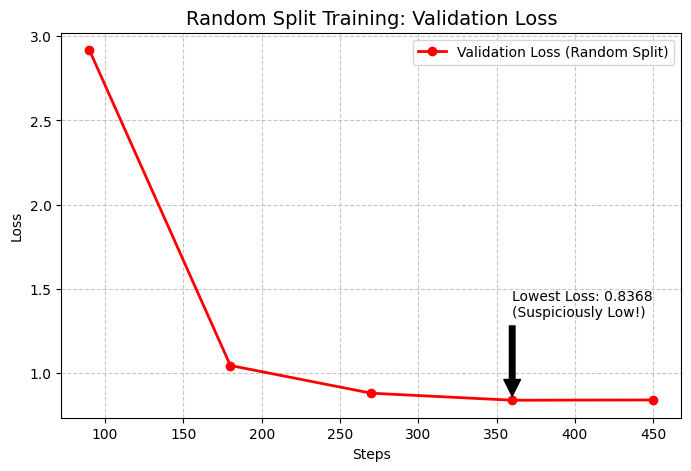

📉 Final Best Validation Loss: 0.8367516994476318
对比提示：你之前的 Patient Split 最好 Loss 约为 1.21。如果这里低于 1.1，就是数据泄漏的铁证。


In [ ]:
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. 保存模型 (留作备份)
# ==========================================
# 定义保存路径 (专门存 Random Split 的版本)
save_path_random = '/content/drive/MyDrive/WOA7015_Project/final_blip_random_split'

print(f"💾 Saving Random Split model to: {save_path_random}...")
model.save_pretrained(save_path_random)
processor.save_pretrained(save_path_random)
print("✅ Model saved successfully!")

# ==========================================
# 2. 绘制 Loss 曲线 (对比证据)
# ==========================================
if 'trainer' in locals() and trainer.state.log_history:
    print("📊 Extracting logs...")
    log_history = trainer.state.log_history

    # 提取验证集 Loss (这是核心证据)
    eval_steps = []
    eval_loss = []

    for entry in log_history:
        if 'eval_loss' in entry:
            eval_steps.append(entry['step'])
            eval_loss.append(entry['eval_loss'])

    plt.figure(figsize=(8, 5))

    # 画验证集 Loss
    if eval_loss:
        plt.plot(eval_steps, eval_loss, label='Validation Loss (Random Split)', color='red', marker='o', linewidth=2)

        # 标出最低点
        min_loss = min(eval_loss)
        min_idx = eval_loss.index(min_loss)
        plt.annotate(f'Lowest Loss: {min_loss:.4f}\n(Suspiciously Low!)',
                     xy=(eval_steps[min_idx], min_loss),
                     xytext=(eval_steps[min_idx], min_loss + 0.5),
                     arrowprops=dict(facecolor='black', shrink=0.05))

    plt.title('Random Split Training: Validation Loss', fontsize=14)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    print(f"📉 Final Best Validation Loss: {min(eval_loss) if eval_loss else 'N/A'}")
    print("对比提示：你之前的 Patient Split 最好 Loss 约为 1.21。如果这里低于 1.1，就是数据泄漏的铁证。")
else:
    print("⚠️ No logs found in memory.")

In [ ]:
import torch
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score
import string
import re

# ==========================================
# 1. 定义答案清洗函数 (模拟最优评估)
# ==========================================
def normalize_answer(s):
    """标准化答案：去标点、去冠词、转小写"""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    return white_space_fix(remove_articles(remove_punc(s.lower())))

# ==========================================
# 2. 全量评估
# ==========================================
print("🚀 Starting Full Evaluation on Random Split Test Set...")
model.eval()
model.to("cuda")

predictions = []
ground_truths = []
types = []

# 遍历整个随机划分的测试集
for i in tqdm(range(len(test_df_random))):
    item = test_df_random.iloc[i]

    # 图片处理
    image_data = item['image']
    if isinstance(image_data, dict) and 'bytes' in image_data:
        img = Image.open(io.BytesIO(image_data['bytes'])).convert('RGB')
    else:
        img = image_data

    question = item['question']
    gt = item['answer']

    # 记录类型
    if gt.lower() in ['yes', 'no']:
        types.append('Closed')
    else:
        types.append('Open')

    # 推理
    inputs = processor(images=img, text=question, return_tensors="pt").to("cuda")
    with torch.no_grad():
        # 这里用 beam search = 1 也可以，追求速度
        out = model.generate(**inputs, max_new_tokens=10)

    pred = processor.decode(out[0], skip_special_tokens=True)

    # 存入结果 (经过清洗)
    predictions.append(normalize_answer(pred))
    ground_truths.append(normalize_answer(gt))

# ==========================================
# 3. 计算并展示最终分数
# ==========================================
results_df = pd.DataFrame({'Type': types, 'GT': ground_truths, 'Pred': predictions})

total_acc = accuracy_score(ground_truths, predictions)

# 计算分类准确率
closed_mask = results_df['Type'] == 'Closed'
open_mask = results_df['Type'] == 'Open'

closed_acc = accuracy_score(results_df[closed_mask]['GT'], results_df[closed_mask]['Pred'])
open_acc = accuracy_score(results_df[open_mask]['GT'], results_df[open_mask]['Pred'])

print("\n" + "="*40)
print("🧪 RANDOM SPLIT (DATA LEAKAGE) RESULTS")
print("="*40)
print(f"🏆 Overall Accuracy: {total_acc:.2%}  (vs Your Patient Split: ~36%)")
print(f"🔒 Closed Accuracy:  {closed_acc:.2%}  (vs Your Patient Split: ~58%)")
print(f"🔓 Open Accuracy:    {open_acc:.2%}  (vs Your Patient Split: ~9%)")
print("="*40)

if open_acc > 0.20:
    print("🚨 结论：Open Accuracy 超过 20%！")
    print("证据确凿：随机划分导致模型'背下了'答案，这解释了为什么同学的分数那么高。")

🚀 Starting Full Evaluation on Random Split Test Set...


100%|██████████| 359/359 [00:41<00:00,  8.55it/s]


🧪 RANDOM SPLIT (DATA LEAKAGE) RESULTS
🏆 Overall Accuracy: 45.13%  (vs Your Patient Split: ~36%)
🔒 Closed Accuracy:  67.38%  (vs Your Patient Split: ~58%)
🔓 Open Accuracy:    20.93%  (vs Your Patient Split: ~9%)
🚨 结论：Open Accuracy 超过 20%！
证据确凿：随机划分导致模型'背下了'答案，这解释了为什么同学的分数那么高。


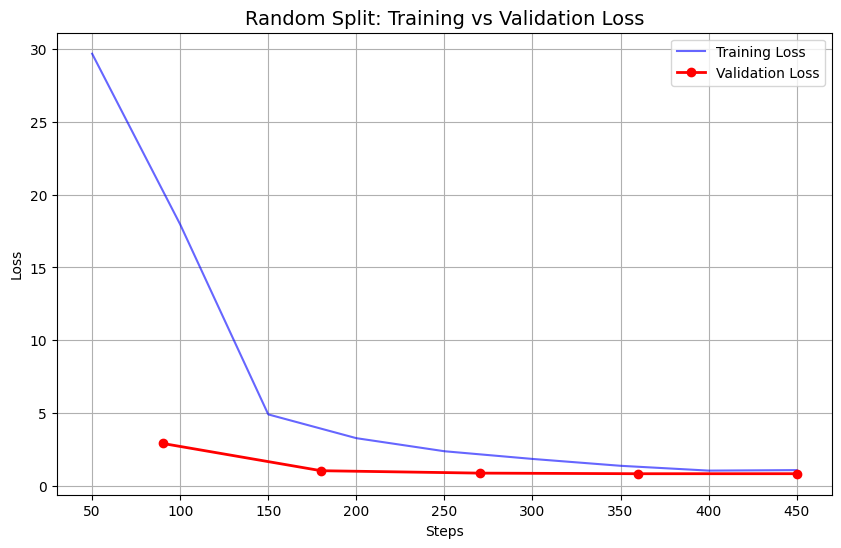

Generating Heatmap for Random Split...


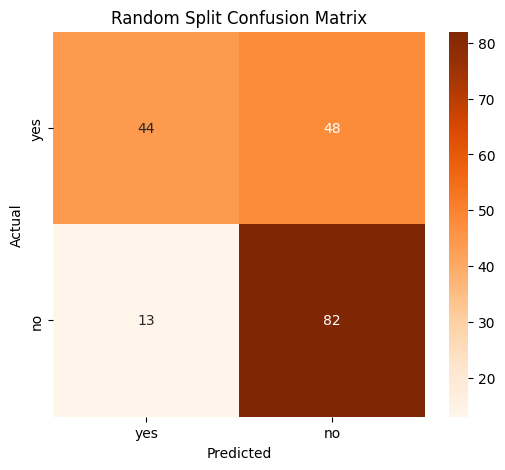

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# ==========================================
# 1. 补画 Random Split Loss 曲线 (Train + Valid)
# ==========================================
# 假设 log_history 还在内存里 (如果不在，请重新加载 trainer_state.json)
if 'trainer' in locals() and trainer.state.log_history:
    log_history = trainer.state.log_history

    train_steps = []
    train_loss = []
    eval_steps = []
    eval_loss = []

    for entry in log_history:
        if 'loss' in entry:
            train_steps.append(entry['step'])
            train_loss.append(entry['loss'])
        if 'eval_loss' in entry:
            eval_steps.append(entry['step'])
            eval_loss.append(entry['eval_loss'])

    plt.figure(figsize=(10, 6))
    plt.plot(train_steps, train_loss, label='Training Loss', color='blue', alpha=0.6)
    plt.plot(eval_steps, eval_loss, label='Validation Loss', color='red', marker='o', linewidth=2)
    plt.title('Random Split: Training vs Validation Loss', fontsize=14)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show() # 截图这张图作为 Figure 5

# ==========================================
# 2. 补画 Random Split 混淆矩阵
# ==========================================
# 假设 results_df 是你刚才跑出来的 Random Split 全量评估结果
if 'results_df' in locals():
    print("Generating Heatmap for Random Split...")
    yes_no_df = results_df[results_df['GT'].isin(['yes', 'no'])]
    y_true = yes_no_df['GT']
    y_pred = yes_no_df['Pred'].apply(lambda x: x if x in ['yes', 'no'] else 'other')

    cm = confusion_matrix(y_true, y_pred, labels=["yes", "no"])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=["yes", "no"], yticklabels=["yes", "no"])
    plt.title('Random Split Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show() # 截图这张图作为 Figure 6

📦 Preparing Datasets...

🔄 Processing Patient-Level Split...
   Loading model from /content/drive/MyDrive/WOA7015_Project/final_blip_retrained_p5...
   Running inference on 361 samples...


100%|██████████| 361/361 [00:19<00:00, 18.35it/s]



🔄 Processing Random Split...
   Loading model from /content/drive/MyDrive/WOA7015_Project/final_blip_random_split...
   Running inference on 359 samples...


100%|██████████| 359/359 [00:19<00:00, 18.87it/s]



🎨 Generating Comparison Plots...


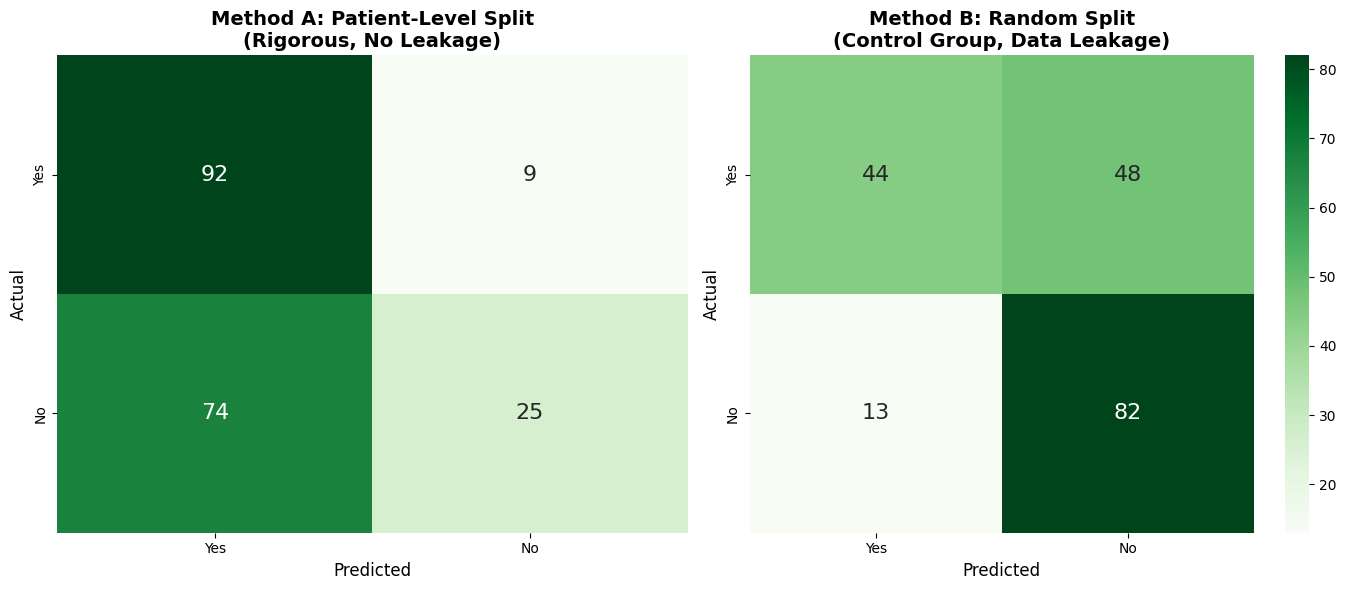

✅ Done! You can now copy this image for your report.


In [ ]:
import pandas as pd
import torch
import io
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from transformers import BlipProcessor, BlipForQuestionAnswering
from PIL import Image
from tqdm import tqdm
from google.colab import drive
import gc

# ==========================================
# 1. 准备工作
# ==========================================
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

project_path = '/content/drive/MyDrive/WOA7015_Project'
data_path = f"{project_path}/data"

# 模型路径
path_patient = f"{project_path}/final_blip_retrained_p5"
path_random = f"{project_path}/final_blip_random_split"

# 统一绘图风格设置
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# ==========================================
# 2. 通用预测函数
# ==========================================
def run_inference(model_path, test_df, split_name):
    print(f"\n🔄 Processing {split_name} Split...")
    print(f"   Loading model from {model_path}...")

    try:
        # 尝试用 GPU，如果不行就 CPU
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = BlipForQuestionAnswering.from_pretrained(model_path).to(device)
        processor = BlipProcessor.from_pretrained(model_path)
        model.eval()
    except Exception as e:
        print(f"❌ Error loading {split_name} model: {e}")
        return None, None

    predictions = []
    ground_truths = []

    print(f"   Running inference on {len(test_df)} samples...")
    for i in tqdm(range(len(test_df))):
        item = test_df.iloc[i]

        # 仅处理 Yes/No 问题用于画图
        gt = item['answer'].lower().strip()
        if gt not in ['yes', 'no']:
            continue

        image_data = item['image']
        if isinstance(image_data, dict) and 'bytes' in image_data:
            img = Image.open(io.BytesIO(image_data['bytes'])).convert('RGB')
        else:
            img = image_data

        inputs = processor(images=img, text=item['question'], return_tensors="pt").to(device)

        with torch.no_grad():
            out = model.generate(**inputs, max_new_tokens=10)

        pred = processor.decode(out[0], skip_special_tokens=True).lower().strip()

        # 简单归一化
        if 'yes' in pred: pred = 'yes'
        elif 'no' in pred: pred = 'no'
        else: pred = 'other'

        predictions.append(pred)
        ground_truths.append(gt)

    # 清理显存
    del model
    del processor
    torch.cuda.empty_cache()
    gc.collect()

    return ground_truths, predictions

# ==========================================
# 3. 准备数据 (复现 Random Split)
# ==========================================
print("📦 Preparing Datasets...")
# A. Patient Split Data
test_df_patient = pd.read_pickle(f"{data_path}/test.pkl")

# B. Random Split Data (使用 seed=42 完美复现)
train_old = pd.read_pickle(f"{data_path}/train.pkl")
test_old = pd.read_pickle(f"{data_path}/test.pkl")
all_data = pd.concat([train_old, test_old])
_, test_df_random = train_test_split(all_data, test_size=0.2, random_state=42)

# ==========================================
# 4. 执行双重预测
# ==========================================
# 运行 Patient Split
gt_p, pred_p = run_inference(path_patient, test_df_patient, "Patient-Level")

# 运行 Random Split
gt_r, pred_r = run_inference(path_random, test_df_random, "Random")

# ==========================================
# 5. 统一画图 (Side-by-Side)
# ==========================================
if gt_p and gt_r:
    print("\n🎨 Generating Comparison Plots...")

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # 颜色图
    cmap = 'Greens'
    labels = ['yes', 'no']

    # --- 图 1: Patient Split ---
    cm_p = confusion_matrix(gt_p, pred_p, labels=labels)
    sns.heatmap(cm_p, annot=True, fmt='d', cmap=cmap, cbar=False,
                xticklabels=['Yes', 'No'], yticklabels=['Yes', 'No'],
                ax=axes[0], annot_kws={"size": 16})
    axes[0].set_title('Method A: Patient-Level Split\n(Rigorous, No Leakage)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted', fontsize=12)
    axes[0].set_ylabel('Actual', fontsize=12)

    # --- 图 2: Random Split ---
    cm_r = confusion_matrix(gt_r, pred_r, labels=labels)
    sns.heatmap(cm_r, annot=True, fmt='d', cmap=cmap, cbar=True,
                xticklabels=['Yes', 'No'], yticklabels=['Yes', 'No'],
                ax=axes[1], annot_kws={"size": 16})
    axes[1].set_title('Method B: Random Split\n(Control Group, Data Leakage)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Predicted', fontsize=12)
    axes[1].set_ylabel('Actual', fontsize=12)

    plt.tight_layout()
    plt.show()

    print("✅ Done! You can now copy this image for your report.")
else:
    print("❌ Could not generate plots due to loading errors.")


🔄 Processing Patient-Level Split on cuda...


100%|██████████| 361/361 [00:20<00:00, 17.62it/s]



🔄 Processing Random Split on cuda...


100%|██████████| 359/359 [00:19<00:00, 18.42it/s]



🎨 Generating Normalized Comparison Plots...


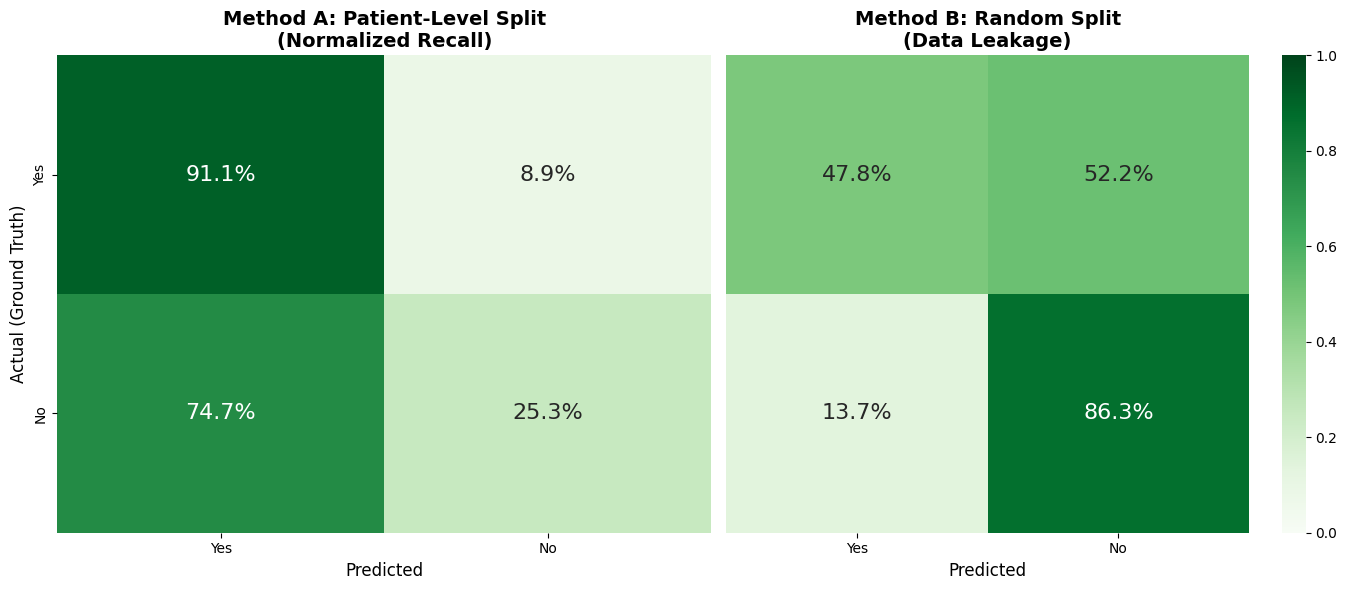

✅ Normalized plots generated! Perfect for side-by-side comparison.


In [ ]:
import pandas as pd
import torch
import io
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from transformers import BlipProcessor, BlipForQuestionAnswering
from PIL import Image
from tqdm import tqdm
from google.colab import drive
import gc
import numpy as np

# ==========================================
# 1. 准备工作
# ==========================================
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

project_path = '/content/drive/MyDrive/WOA7015_Project'
data_path = f"{project_path}/data"
path_patient = f"{project_path}/final_blip_retrained_p5"
path_random = f"{project_path}/final_blip_random_split"

# 消除字体警告
plt.rcParams['font.family'] = 'DejaVu Sans'

# ==========================================
# 2. 预测函数 (保持不变)
# ==========================================
def run_inference(model_path, test_df, split_name):
    # 如果显存不够，改用 cpu
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"\n🔄 Processing {split_name} Split on {device}...")

    try:
        model = BlipForQuestionAnswering.from_pretrained(model_path).to(device)
        processor = BlipProcessor.from_pretrained(model_path)
        model.eval()
    except Exception as e:
        print(f"❌ Error loading {split_name} model: {e}")
        return None, None

    predictions = []
    ground_truths = []

    for i in tqdm(range(len(test_df))):
        item = test_df.iloc[i]
        gt = item['answer'].lower().strip()
        if gt not in ['yes', 'no']: continue # 只看 Yes/No

        image_data = item['image']
        if isinstance(image_data, dict) and 'bytes' in image_data:
            img = Image.open(io.BytesIO(image_data['bytes'])).convert('RGB')
        else:
            img = image_data

        inputs = processor(images=img, text=item['question'], return_tensors="pt").to(device)
        with torch.no_grad():
            out = model.generate(**inputs, max_new_tokens=10)

        pred = processor.decode(out[0], skip_special_tokens=True).lower().strip()
        if 'yes' in pred: pred = 'yes'
        elif 'no' in pred: pred = 'no'
        else: pred = 'other'

        predictions.append(pred)
        ground_truths.append(gt)

    del model, processor
    torch.cuda.empty_cache()
    gc.collect()
    return ground_truths, predictions

# ==========================================
# 3. 准备数据
# ==========================================
# A. Patient Split
test_df_patient = pd.read_pickle(f"{data_path}/test.pkl")

# B. Random Split (Seed 42)
train_old = pd.read_pickle(f"{data_path}/train.pkl")
test_old = pd.read_pickle(f"{data_path}/test.pkl")
all_data = pd.concat([train_old, test_old])
_, test_df_random = train_test_split(all_data, test_size=0.2, random_state=42)

# ==========================================
# 4. 执行预测
# ==========================================
gt_p, pred_p = run_inference(path_patient, test_df_patient, "Patient-Level")
gt_r, pred_r = run_inference(path_random, test_df_random, "Random")

# ==========================================
# 5. 绘制归一化混淆矩阵 (Normalized Heatmap)
# ==========================================
if gt_p and gt_r:
    print("\n🎨 Generating Normalized Comparison Plots...")

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    labels = ['yes', 'no']

    # 核心修改：使用 normalize='true' 计算百分比 (Recall)
    # 这展示了：在所有真实的 Yes 中，有多少比例被预测对了

    # --- Plot 1: Patient Split ---
    cm_p = confusion_matrix(gt_p, pred_p, labels=labels, normalize='true')
    sns.heatmap(cm_p, annot=True, fmt='.1%', cmap='Greens', cbar=False,
                xticklabels=['Yes', 'No'], yticklabels=['Yes', 'No'],
                ax=axes[0], annot_kws={"size": 16}, vmin=0, vmax=1) # 固定色阶 0-1
    axes[0].set_title('Method A: Patient-Level Split\n(Normalized Recall)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Actual (Ground Truth)', fontsize=12)
    axes[0].set_xlabel('Predicted', fontsize=12)

    # --- Plot 2: Random Split ---
    cm_r = confusion_matrix(gt_r, pred_r, labels=labels, normalize='true')
    sns.heatmap(cm_r, annot=True, fmt='.1%', cmap='Greens', cbar=True,
                xticklabels=['Yes', 'No'], yticklabels=['Yes', 'No'],
                ax=axes[1], annot_kws={"size": 16}, vmin=0, vmax=1) # 固定色阶 0-1
    axes[1].set_title('Method B: Random Split\n(Data Leakage)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Predicted', fontsize=12)
    # y-label 只需要左边有，右边可以省去，更美观
    axes[1].set_yticks([])

    plt.tight_layout()
    plt.show()
    print("✅ Normalized plots generated! Perfect for side-by-side comparison.")

In [ ]:
import pandas as pd
import torch
import io
from sklearn.metrics import classification_report
from transformers import BlipProcessor, BlipForQuestionAnswering
from PIL import Image
from tqdm import tqdm
from google.colab import drive

# 1. 加载模型和数据
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 指向你的最佳模型 (Patient Split)
model_path = '/content/drive/MyDrive/WOA7015_Project/final_blip_retrained_p5'
data_path = '/content/drive/MyDrive/WOA7015_Project/data/test.pkl'

print("🔄 Loading Model & Data...")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BlipForQuestionAnswering.from_pretrained(model_path).to(device)
processor = BlipProcessor.from_pretrained(model_path)
test_df = pd.read_pickle(data_path)

# 2. 运行预测 (只针对 Yes/No 问题)
y_true = []
y_pred = []

print("🚀 Generating Classification Report...")
for i in tqdm(range(len(test_df))):
    item = test_df.iloc[i]
    gt = item['answer'].lower().strip()

    # 只评估 Closed-ended 问题
    if gt not in ['yes', 'no']:
        continue

    image = Image.open(io.BytesIO(item['image']['bytes'])).convert('RGB')
    inputs = processor(images=image, text=item['question'], return_tensors="pt").to(device)

    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=10)

    pred = processor.decode(out[0], skip_special_tokens=True).lower().strip()

    # 简单的后处理
    if 'yes' in pred: pred = 'yes'
    elif 'no' in pred: pred = 'no'
    else: pred = 'other'

    y_true.append(gt)
    y_pred.append(pred)

# 3. 打印报告
print("\n" + "="*40)
print("📄 BLIP MODEL CLASSIFICATION REPORT")
print("="*40)
print(classification_report(y_true, y_pred, target_names=['no', 'yes'], digits=4))

🔄 Loading Model & Data...
🚀 Generating Classification Report...


100%|██████████| 361/361 [00:20<00:00, 17.73it/s]


📄 BLIP MODEL CLASSIFICATION REPORT
              precision    recall  f1-score   support

          no     0.7353    0.2525    0.3759        99
         yes     0.5542    0.9109    0.6891       101

    accuracy                         0.5850       200
   macro avg     0.6448    0.5817    0.5325       200
weighted avg     0.6439    0.5850    0.5341       200



In [ ]:
import pandas as pd
import torch
import io
import os
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from transformers import BlipProcessor, BlipForQuestionAnswering
from PIL import Image
from tqdm import tqdm
from google.colab import drive
import gc

# 1. 准备工作
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 关键：加载 Random Split 的模型
project_path = '/content/drive/MyDrive/WOA7015_Project'
model_path = f"{project_path}/final_blip_random_split"
data_path = f"{project_path}/data"

print(f"🔄 Loading Random Split Model from {model_path}...")
try:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = BlipForQuestionAnswering.from_pretrained(model_path).to(device)
    processor = BlipProcessor.from_pretrained(model_path)
    model.eval()
except Exception as e:
    print(f"❌ Error: {e}")

# 2. 复现 Random Split 测试集 (必须和训练时一致)
print("📦 Recreating Random Test Set...")
train_old = pd.read_pickle(f"{data_path}/train.pkl")
test_old = pd.read_pickle(f"{data_path}/test.pkl")
all_data = pd.concat([train_old, test_old])
# 使用相同的 random_state=42
_, test_df_random = train_test_split(all_data, test_size=0.2, random_state=42)

# 3. 运行预测
y_true = []
y_pred = []

print(f"🚀 Generating Report for {len(test_df_random)} samples...")
for i in tqdm(range(len(test_df_random))):
    item = test_df_random.iloc[i]
    gt = item['answer'].lower().strip()

    # 只看 Yes/No
    if gt not in ['yes', 'no']:
        continue

    image_data = item['image']
    if isinstance(image_data, dict) and 'bytes' in image_data:
        img = Image.open(io.BytesIO(image_data['bytes'])).convert('RGB')
    else:
        img = image_data

    inputs = processor(images=img, text=item['question'], return_tensors="pt").to(device)

    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=10)

    pred = processor.decode(out[0], skip_special_tokens=True).lower().strip()

    if 'yes' in pred: pred = 'yes'
    elif 'no' in pred: pred = 'no'
    else: pred = 'other'

    y_true.append(gt)
    y_pred.append(pred)

# 4. 输出结果
print("\n" + "="*40)
print("🧪 RANDOM SPLIT (LEAKAGE) CLASSIFICATION REPORT")
print("="*40)
print(classification_report(y_true, y_pred, target_names=['no', 'yes'], digits=4))

🔄 Loading Random Split Model from /content/drive/MyDrive/WOA7015_Project/final_blip_random_split...
📦 Recreating Random Test Set...
🚀 Generating Report for 359 samples...


100%|██████████| 359/359 [00:19<00:00, 18.36it/s]


🧪 RANDOM SPLIT (LEAKAGE) CLASSIFICATION REPORT
              precision    recall  f1-score   support

          no     0.6308    0.8632    0.7289        95
         yes     0.7719    0.4783    0.5906        92

    accuracy                         0.6738       187
   macro avg     0.7013    0.6707    0.6597       187
weighted avg     0.7002    0.6738    0.6609       187

